In [22]:
from hamp_pred.src.predictor import Predictor
from hamp_pred.src.predictor_config import DEFAULT_CONF, PredictionConfig,SEQ_ENCODING_EXTERNAL
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from Bio import SeqIO
import tensorflow as tf
from Bio.PDB.Polypeptide import aa1
from external.SequenceEncoding.SequenceEncoding import SequenceEncoding, get_dict
from hamp_pred.src.input_prep.encode import OneHotEncoderSeq, RadianEncoder, MixedEncoder, MultiEncoder
from hamp_pred.src.input_prep.prepare_sequence import MultiChainOperator, SeqWindow
from hamp_pred.src.models.common.models import BaseConvolutionalWrapper, BaseLinearWrapper
from hamp_pred.src.input_prep.encode import RadiousPhobosEncoder
from keras.utils.vis_utils import plot_model
from Bio.PDB.PDBParser import PDBParser
import os
import pickle
import matplotlib.pyplot as plt

In [57]:
def get_true_and_pred(data):
    adj = data.copy()
    adj['n_seq'] = adj['n_seq'].apply(lambda x:x[1:-1])
    adj['c_seq'] = adj['c_seq'].apply(lambda x:x[1:-1])
    seq = []
    tr = []
    for n,r in adj.iterrows():
        seq.append(r['n_seq'] + r['c_seq'])
        tr.append(np.mean((r['rot'][0::2] + r['rot'][1::2]) / 2)/2)
    res = mod.predict(seq)
    pr = []
    for n,r in res.iterrows():
        pr.append(np.mean(r['N_pred'])/2)
    return tr, pr, seq

def get_true_pred_plot(tr, pr, ylabel='', title=''):
    fig, ax = plt.subplots(1,1, figsize=(6, 6), dpi=100)
    ax.scatter(pr, tr, color='green', s=25)
    ax.set_ylim(-26, 26)
    ax.set_xlim(-26, 26)
    ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey')
    ax.set_xlabel('Predicted', size=15)
    ax.set_ylabel(ylabel, size=15)
    ax.set_title(title)
    return ax

In [58]:
mod=Predictor('hamp_rot')

In [59]:
DATA_DIR = '/home/users/sdunin/calc/TCST'
data = f'{DATA_DIR}/offline_data/cache/af2_true_full.features.p'
data = pd.read_pickle(data)

## Validation set results 

In [60]:
val_ids = set(data[data['class'] == 'val'].index)
idx = list(data.index)
val = data.loc[val_ids]
tr, pr, seqs = get_true_and_pred(val)

/tmp/ipykernel_16783/3634892074.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  val = data.loc[val_ids]


Encoded 1/448 sequences
Encoded 2/448 sequences
Encoded 3/448 sequences
Encoded 4/448 sequences
Encoded 5/448 sequences
Encoded 6/448 sequences
Encoded 7/448 sequences
Encoded 8/448 sequences
Encoded 9/448 sequences
Encoded 10/448 sequences
Encoded 11/448 sequences
Encoded 12/448 sequences
Encoded 13/448 sequences
Encoded 14/448 sequences
Encoded 15/448 sequences
Encoded 16/448 sequences
Encoded 17/448 sequences
Encoded 18/448 sequences
Encoded 19/448 sequences
Encoded 20/448 sequences
Encoded 21/448 sequences
Encoded 22/448 sequences
Encoded 23/448 sequences
Encoded 24/448 sequences
Encoded 25/448 sequences
Encoded 26/448 sequences
Encoded 27/448 sequences
Encoded 28/448 sequences
Encoded 29/448 sequences
Encoded 30/448 sequences
Encoded 31/448 sequences
Encoded 32/448 sequences
Encoded 33/448 sequences
Encoded 34/448 sequences
Encoded 35/448 sequences
Encoded 36/448 sequences
Encoded 37/448 sequences
Encoded 38/448 sequences
Encoded 39/448 sequences
Encoded 40/448 sequences
Encoded 4

1/1 [==============================] - 2s 2s/step


<AxesSubplot:title={'center':'Predictions for validation set'}, xlabel='Predicted', ylabel='True'>

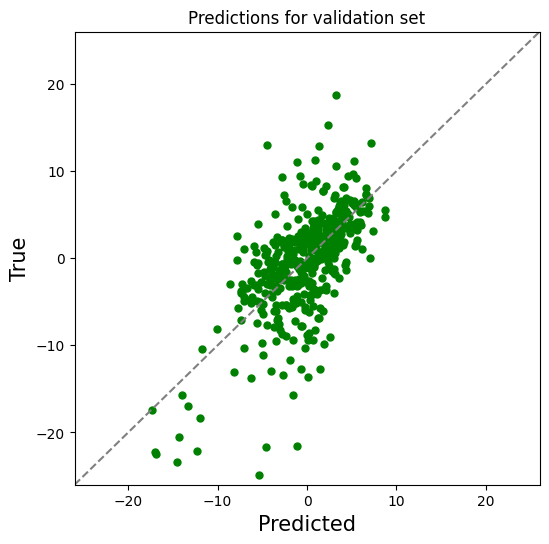

In [56]:
get_true_pred_plot(tr, pr, 'True', "Predictions for validation set")

## Validation MSE per position

In [13]:
mn = val['rot'].apply(lambda x: (x[0::2] + x[1::2]) / 2)
l = np.concatenate(res['N_pred'].values)
r = np.concatenate(mn.values).reshape(l.shape)
np.mean((r - l) ** 2)

103.67761190150094

In [14]:
np.mean((np.array(tr)-np.array(pr)) **2 ) ** 0.5

4.580893659420226

## Validation set results 

In [64]:
test_data = pd.read_pickle('../../TCST/hamp_svm/pdb_measure.p')
# mutants removal
test_data.rename(columns={'seq1':'n_seq', 'seq2':'c_seq'}, inplace=True)
test_data=test_data.drop(['5jeq.pdb',
            '5jef.pdb',
            '3zrv.pdb',
            '2lfs.pdb',
            '3zrw.pdb',
            '3zcc.pdb',
            '2l7i.pdb', '2y20.pdb', '2y21.pdb', '2y0q.pdb',
                    
            '3lnr.pdb', 
                    '4i44.pdb', '4i3m.pdb'

           
           ])
tr, pr, test_wild_seqs = get_true_and_pred(test_data)

Encoded 1/16 sequences
Encoded 2/16 sequences
Encoded 3/16 sequences
Encoded 4/16 sequences
Encoded 5/16 sequences
Encoded 6/16 sequences
Encoded 7/16 sequences
Encoded 8/16 sequences
Encoded 9/16 sequences
Encoded 10/16 sequences
Encoded 11/16 sequences
Encoded 12/16 sequences
Encoded 13/16 sequences
Encoded 14/16 sequences
Encoded 15/16 sequences
Encoded 16/16 sequences
Encoded 1/16 sequences
Encoded 2/16 sequences
Encoded 3/16 sequences
Encoded 4/16 sequences
Encoded 5/16 sequences
Encoded 6/16 sequences
Encoded 7/16 sequences
Encoded 8/16 sequences
Encoded 9/16 sequences
Encoded 10/16 sequences
Encoded 11/16 sequences
Encoded 12/16 sequences
Encoded 13/16 sequences
Encoded 14/16 sequences
Encoded 15/16 sequences
Encoded 16/16 sequences
1/1 [==============================] - 1s 1s/step


<AxesSubplot:title={'center':'Predictions for WT HAMPs (no mutants)'}, xlabel='Predicted', ylabel='PDB structure'>

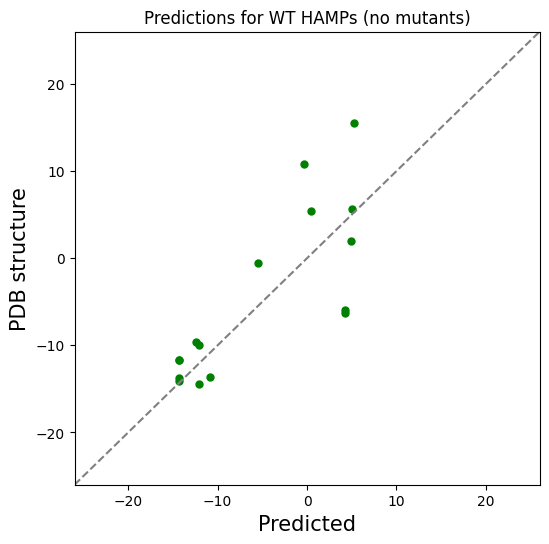

In [65]:
get_true_pred_plot(tr, pr, 'PDB structure', "Predictions for WT HAMPs (no mutants)")

In [37]:
np.mean((np.array(tr)-np.array(pr)) **2 ) ** 0.5

5.8074650035105355

In [66]:
test_data = pd.read_pickle('../../TCST/hamp_svm/pdb_measure.p')
# mutants removal
test_data.rename(columns={'seq1':'n_seq', 'seq2':'c_seq'}, inplace=True)
test_data=test_data.loc[['5jeq.pdb',
            '5jef.pdb',
            '3zrv.pdb',
            '2lfs.pdb',
            '3zrw.pdb',
            '3zcc.pdb',
            '2l7i.pdb', '2y20.pdb', '2y21.pdb', '2y0q.pdb',
                    
            '3lnr.pdb', 
                    '4i44.pdb', '4i3m.pdb'

           
           ]]

In [71]:
test_data

n_rot      c_rot          n_seq          c_seq      color  \
pdb                                                                       
5jeq.pdb  -1.240361  -7.473836  PLNQLVTASQRIE  ELGLLAKTFNQMS  lightgrey   
5jef.pdb   4.383736   2.781244  PLNQLVTASQRIE  ELGLLAKTFNQMS  lightgrey   
3zrv.pdb -20.640864   2.228192  PIIELSNTFDKIA  EIGILAKSIERLR  lightgrey   
2lfs.pdb   0.821560   2.794088  PIIELSNTFDKIA  EIGILAKSIERLR  lightgrey   
3zrw.pdb -14.951743   0.978725  PIIELSNTVDKIA  EIGILAKSIERLR  lightgrey   
3zcc.pdb -23.849375   5.440649  PIIELSNTADKIA  EIGILAKSIERLR  lightgrey   
2l7i.pdb   0.212011   3.933485  PIIELSNTFDKIA  EIGILAKSIERLR  lightgrey   
2y20.pdb -18.736343   7.062672  PIIELSNTIDKIA  EIGILAKSIERLR  lightgrey   
2y21.pdb -17.299223   3.459582  PIIELSNTVDKIA  EIGILAKSIERLR  lightgrey   
2y0q.pdb -17.979150   1.242494  PIIELSNTCDKIA  EIGILAKSIERLR  lightgrey   
3lnr.pdb  -4.326787   5.352000  RADRIATLLQSFA  GYERLYDSLRALQ  lightgrey   
3lnr.pdb  23.110307 -11.239460  LEAGLAEMSRQHE  RAARIAKGVNELV  lightgrey   
3lnr.pdb  -7.711330  10.815936  VKMKVVSVVTAYG  KKAQITEAIDGVR  lightgrey   
4i44.pdb  -5.500299   5.106334  RADRIATLLQSFA  GYERLYDSLRALQ  lightgrey   
4i44.pdb  24.572453 -13.002732  LEAGLAEMSRQHE  RAARIAKGVNELV  lightgrey   
4i44.pdb -11.804309  10.512143  VKMKVVSVVTAYG  KKAQITEAIDGVR  lightgrey   
4i3m.pdb  -8.497357  15.422507  RADRIATLLQSFA  GYERHYDSLRALQ  lightgrey   
4i3m.pdb  23.515470 -12.445586  LEAGLAEMSRQHE  RAARIAKGVNELV  lightgrey   
4i3m.pdb -23.140157   6.752818  VKMKVVSVVTAYG  KKAQITEAIDGVR  lightgrey   

                                                     n_list  \
pdb                                                           
5jeq.pdb  [17.56552238683581, 17.565522480639437, 122.45...   
5jef.pdb  [16.615564490798363, 16.42797345412655, 123.25...   
3zrv.pdb  [3.1514535626451523, 5.956338856131813, 103.86...   
2lfs.pdb  [30.42155321313124, 29.3797739872777, 130.0764...   
3zrw.pdb  [8.319007074255254, 7.72821415307694, 108.9216...   
3zcc.pdb  [4.842496281816616, 2.412622251482856, 104.055...   
2l7i.pdb  [30.046690141042358, 29.870238899710994, 129.9...   
2y20.pdb  [4.8490254206099, 7.353972968995644, 105.26845...   
2y21.pdb  [7.083678891068137, 7.243731692449341, 108.815...   
2y0q.pdb  [8.749455296510142, 8.332247502951414, 109.794...   
3lnr.pdb  [24.37261544917754, 24.372615449177527, 126.44...   
3lnr.pdb  [57.618546394628304, 57.618546394628304, 156.6...   
3lnr.pdb  [19.315339677413043, 19.315339677413043, 124.9...   
4i44.pdb  [26.63620077375748, 26.636237250091536, 126.03...   
4i44.pdb  [56.7220939123454, 56.72209658514263, 158.4446...   
4i44.pdb  [17.48397970271121, 17.483979927643098, 122.65...   
4i3m.pdb  [11.913874103697411, 11.913868019882974, 114.7...   
4i3m.pdb  [56.62764334902981, 56.62764352865818, 156.553...   
4i3m.pdb  [4.158077133649519, 4.1580382683943204, 105.55...   

                                                     c_list label  \
pdb                                                                 
5jeq.pdb  [27.56734968516175, 27.567362194054645, 130.05...         
5jef.pdb  [26.010083152793875, 30.234989987010515, 131.2...         
3zrv.pdb  [24.12896342535188, 34.77845918819854, 126.900...         
2lfs.pdb  [32.60006240021754, 31.761116001667407, 132.29...         
3zrw.pdb  [28.14948635581157, 28.057654983722745, 129.50...         
3zcc.pdb  [46.034031865865536, 25.25823650565214, 143.61...         
2l7i.pdb  [31.616712595216924, 31.75597800104769, 132.18...         
2y20.pdb  [38.23368741211337, 38.50687202988876, 141.637...         
2y21.pdb  [31.662792594798677, 30.919029152280665, 134.1...         
2y0q.pdb  [30.54133645838112, 35.05620448184783, 133.773...         
3lnr.pdb  [20.201859638132728, 20.20185963813275, 133.43...    1x   
3lnr.pdb  [28.838794005194643, 28.838794005194643, 128.8...    2x   
3lnr.pdb  [15.463127891670274, 15.463127891670274, 136.1...    3x   
4i44.pdb  [21.13847744472911, 21.138476064272243, 137.17...    1x   
4i44.pdb  

In [68]:
tr, pr, test_mutants_seqs = get_true_and_pred(test_data)

Encoded 1/19 sequences
Encoded 2/19 sequences
Encoded 3/19 sequences
Encoded 4/19 sequences
Encoded 5/19 sequences
Encoded 6/19 sequences
Encoded 7/19 sequences
Encoded 8/19 sequences
Encoded 9/19 sequences
Encoded 10/19 sequences
Encoded 11/19 sequences
Encoded 12/19 sequences
Encoded 13/19 sequences
Encoded 14/19 sequences
Encoded 15/19 sequences
Encoded 16/19 sequences
Encoded 17/19 sequences
Encoded 18/19 sequences
Encoded 19/19 sequences
Encoded 1/19 sequences
Encoded 2/19 sequences
Encoded 3/19 sequences
Encoded 4/19 sequences
Encoded 5/19 sequences
Encoded 6/19 sequences
Encoded 7/19 sequences
Encoded 8/19 sequences
Encoded 9/19 sequences
Encoded 10/19 sequences
Encoded 11/19 sequences
Encoded 12/19 sequences
Encoded 13/19 sequences
Encoded 14/19 sequences
Encoded 15/19 sequences
Encoded 16/19 sequences
Encoded 17/19 sequences
Encoded 18/19 sequences
Encoded 19/19 sequences
1/1 [==============================] - 1s 1s/step


<AxesSubplot:title={'center':'Predictions for HAMPs mutants'}, xlabel='Predicted', ylabel='PDB structure'>

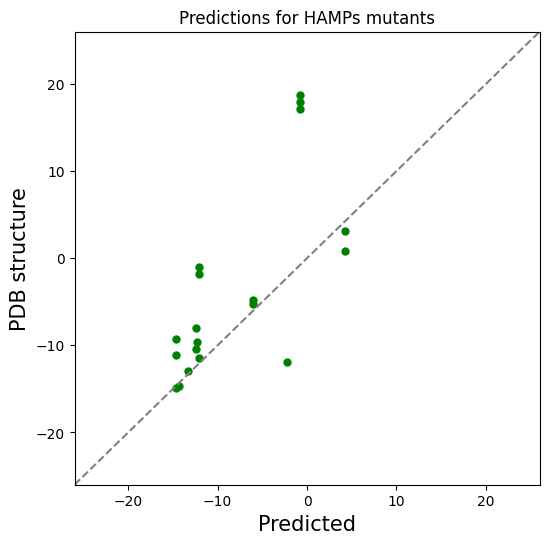

In [72]:
get_true_pred_plot(tr, pr, 'PDB structure', "Predictions for HAMPs mutants")

In [73]:
np.mean((np.array(tr)-np.array(pr)) **2 ) ** 0.5

8.786248227837063

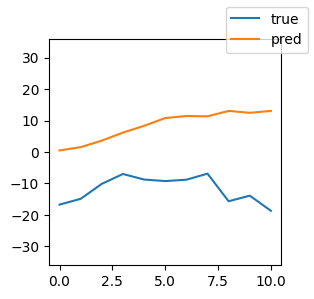

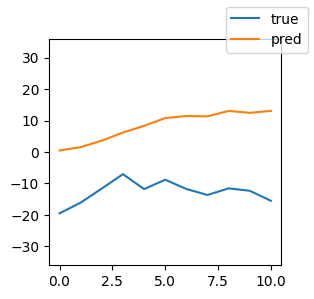

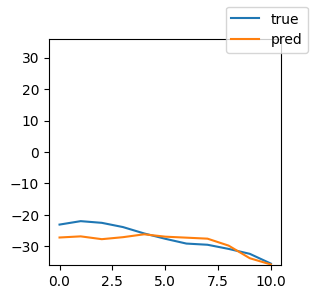

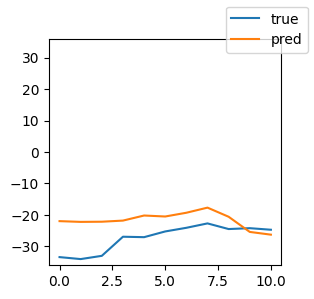

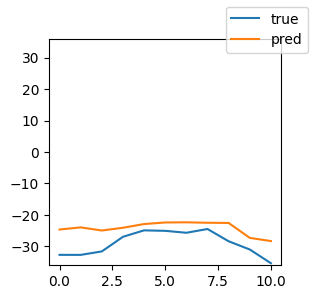

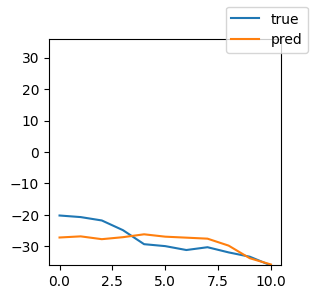

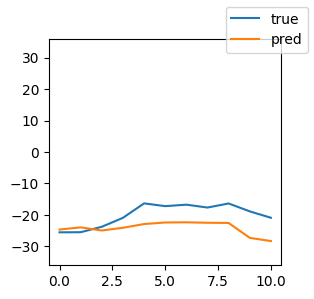

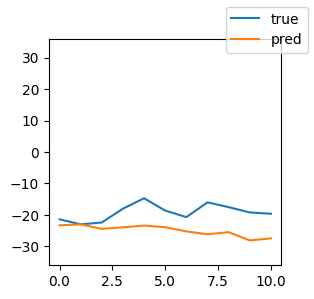

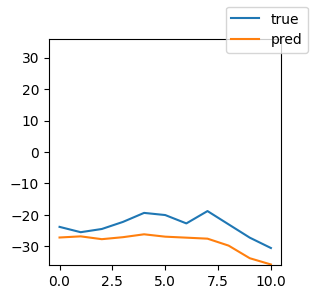

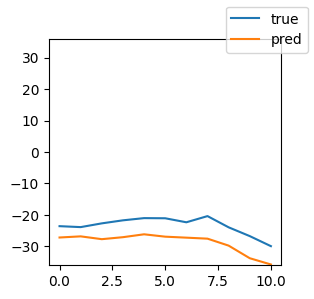

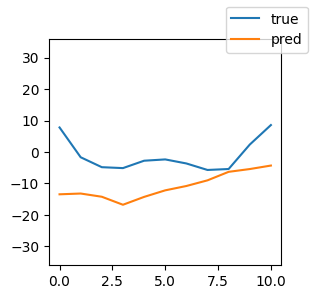

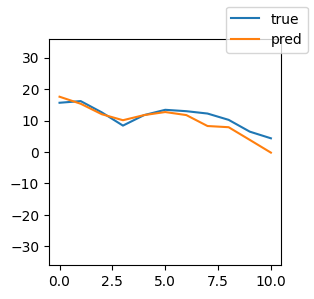

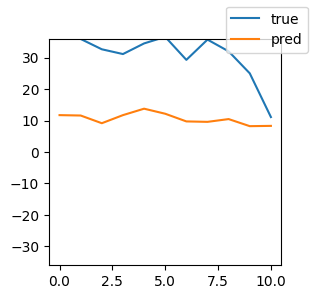

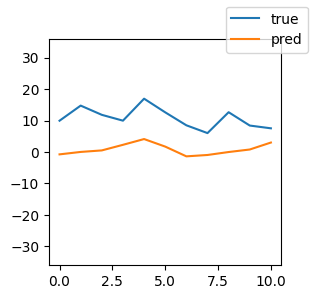

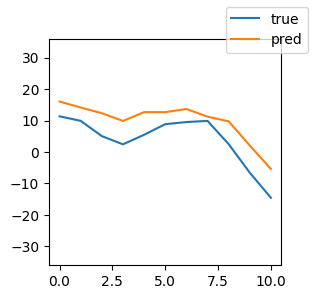

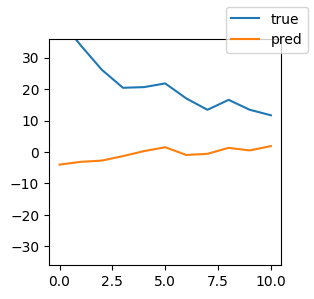

In [18]:
for i in range(len(test_data)):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=100)
    r = test_data.iloc[i]
    tr = (r['rot'][0::2] + r['rot'][1::2]) / 2
    pred = res.iloc[i]['N_pred']
    ax.plot(tr, label='true')
    ax.plot(pred, label='pred')
    ax.set_ylim(-36, 36)
    fig.legend(); pass

## Feature analysis (permutation method)

In [19]:
importance = mod.process_data(seqs, kind='importance_describer')

Encoded 1/448 sequences
Encoded 2/448 sequences
Encoded 3/448 sequences
Encoded 4/448 sequences
Encoded 5/448 sequences
Encoded 6/448 sequences
Encoded 7/448 sequences
Encoded 8/448 sequences
Encoded 9/448 sequences
Encoded 10/448 sequences
Encoded 11/448 sequences
Encoded 12/448 sequences
Encoded 13/448 sequences
Encoded 14/448 sequences
Encoded 15/448 sequences
Encoded 16/448 sequences
Encoded 17/448 sequences
Encoded 18/448 sequences
Encoded 19/448 sequences
Encoded 20/448 sequences
Encoded 21/448 sequences
Encoded 22/448 sequences
Encoded 23/448 sequences
Encoded 24/448 sequences
Encoded 25/448 sequences
Encoded 26/448 sequences
Encoded 27/448 sequences
Encoded 28/448 sequences
Encoded 29/448 sequences
Encoded 30/448 sequences
Encoded 31/448 sequences
Encoded 32/448 sequences
Encoded 33/448 sequences
Encoded 34/448 sequences
Encoded 35/448 sequences
Encoded 36/448 sequences
Encoded 37/448 sequences
Encoded 38/448 sequences
Encoded 39/448 sequences
Encoded 40/448 sequences
Encoded 4

1/1 [==============================] - 1s 1s/step
Encoded 1/91920 sequences
Encoded 2/91920 sequences
Encoded 3/91920 sequences
Encoded 4/91920 sequences
Encoded 5/91920 sequences
Encoded 6/91920 sequences
Encoded 7/91920 sequences
Encoded 8/91920 sequences
Encoded 9/91920 sequences
Encoded 10/91920 sequences
Encoded 11/91920 sequences
Encoded 12/91920 sequences
Encoded 13/91920 sequences
Encoded 14/91920 sequences
Encoded 15/91920 sequences
Encoded 16/91920 sequences
Encoded 17/91920 sequences
Encoded 18/91920 sequences
Encoded 19/91920 sequences
Encoded 20/91920 sequences
Encoded 21/91920 sequences
Encoded 22/91920 sequences
Encoded 23/91920 sequences
Encoded 24/91920 sequences
Encoded 25/91920 sequences
Encoded 26/91920 sequences
Encoded 27/91920 sequences
Encoded 28/91920 sequences
Encoded 29/91920 sequences
Encoded 30/91920 sequences
Encoded 31/91920 sequences
Encoded 32/91920 sequences
Encoded 33/91920 sequences
Encoded 34/91920 sequences
Encoded 35/91920 sequences
Encoded 36/919

Encoded 1740/91920 sequences
Encoded 1741/91920 sequences
Encoded 1742/91920 sequences
Encoded 1743/91920 sequences
Encoded 1744/91920 sequences
Encoded 1745/91920 sequences
Encoded 1746/91920 sequences
Encoded 1747/91920 sequences
Encoded 1748/91920 sequences
Encoded 1749/91920 sequences
Encoded 1750/91920 sequences
Encoded 1751/91920 sequences
Encoded 1752/91920 sequences
Encoded 1753/91920 sequences
Encoded 1754/91920 sequences
Encoded 1755/91920 sequences
Encoded 1756/91920 sequences
Encoded 1757/91920 sequences
Encoded 1758/91920 sequences
Encoded 1759/91920 sequences
Encoded 1760/91920 sequences
Encoded 1761/91920 sequences
Encoded 1762/91920 sequences
Encoded 1763/91920 sequences
Encoded 1764/91920 sequences
Encoded 1765/91920 sequences
Encoded 1766/91920 sequences
Encoded 1767/91920 sequences
Encoded 1768/91920 sequences
Encoded 1769/91920 sequences
Encoded 1770/91920 sequences
Encoded 1771/91920 sequences
Encoded 1772/91920 sequences
Encoded 1773/91920 sequences
Encoded 1774/9

Encoded 3132/91920 sequences
Encoded 3133/91920 sequences
Encoded 3134/91920 sequences
Encoded 3135/91920 sequences
Encoded 3136/91920 sequences
Encoded 3137/91920 sequences
Encoded 3138/91920 sequences
Encoded 3139/91920 sequences
Encoded 3140/91920 sequences
Encoded 3141/91920 sequences
Encoded 3142/91920 sequences
Encoded 3143/91920 sequences
Encoded 3144/91920 sequences
Encoded 3145/91920 sequences
Encoded 3146/91920 sequences
Encoded 3147/91920 sequences
Encoded 3148/91920 sequences
Encoded 3149/91920 sequences
Encoded 3150/91920 sequences
Encoded 3151/91920 sequences
Encoded 3152/91920 sequences
Encoded 3153/91920 sequences
Encoded 3154/91920 sequences
Encoded 3155/91920 sequences
Encoded 3156/91920 sequences
Encoded 3157/91920 sequences
Encoded 3158/91920 sequences
Encoded 3159/91920 sequences
Encoded 3160/91920 sequences
Encoded 3161/91920 sequences
Encoded 3162/91920 sequences
Encoded 3163/91920 sequences
Encoded 3164/91920 sequences
Encoded 3165/91920 sequences
Encoded 3166/9

Encoded 4454/91920 sequences
Encoded 4455/91920 sequences
Encoded 4456/91920 sequences
Encoded 4457/91920 sequences
Encoded 4458/91920 sequences
Encoded 4459/91920 sequences
Encoded 4460/91920 sequences
Encoded 4461/91920 sequences
Encoded 4462/91920 sequences
Encoded 4463/91920 sequences
Encoded 4464/91920 sequences
Encoded 4465/91920 sequences
Encoded 4466/91920 sequences
Encoded 4467/91920 sequences
Encoded 4468/91920 sequences
Encoded 4469/91920 sequences
Encoded 4470/91920 sequences
Encoded 4471/91920 sequences
Encoded 4472/91920 sequences
Encoded 4473/91920 sequences
Encoded 4474/91920 sequences
Encoded 4475/91920 sequences
Encoded 4476/91920 sequences
Encoded 4477/91920 sequences
Encoded 4478/91920 sequences
Encoded 4479/91920 sequences
Encoded 4480/91920 sequences
Encoded 4481/91920 sequences
Encoded 4482/91920 sequences
Encoded 4483/91920 sequences
Encoded 4484/91920 sequences
Encoded 4485/91920 sequences
Encoded 4486/91920 sequences
Encoded 4487/91920 sequences
Encoded 4488/9

Encoded 5814/91920 sequences
Encoded 5815/91920 sequences
Encoded 5816/91920 sequences
Encoded 5817/91920 sequences
Encoded 5818/91920 sequences
Encoded 5819/91920 sequences
Encoded 5820/91920 sequences
Encoded 5821/91920 sequences
Encoded 5822/91920 sequences
Encoded 5823/91920 sequences
Encoded 5824/91920 sequences
Encoded 5825/91920 sequences
Encoded 5826/91920 sequences
Encoded 5827/91920 sequences
Encoded 5828/91920 sequences
Encoded 5829/91920 sequences
Encoded 5830/91920 sequences
Encoded 5831/91920 sequences
Encoded 5832/91920 sequences
Encoded 5833/91920 sequences
Encoded 5834/91920 sequences
Encoded 5835/91920 sequences
Encoded 5836/91920 sequences
Encoded 5837/91920 sequences
Encoded 5838/91920 sequences
Encoded 5839/91920 sequences
Encoded 5840/91920 sequences
Encoded 5841/91920 sequences
Encoded 5842/91920 sequences
Encoded 5843/91920 sequences
Encoded 5844/91920 sequences
Encoded 5845/91920 sequences
Encoded 5846/91920 sequences
Encoded 5847/91920 sequences
Encoded 5848/9

Encoded 7164/91920 sequences
Encoded 7165/91920 sequences
Encoded 7166/91920 sequences
Encoded 7167/91920 sequences
Encoded 7168/91920 sequences
Encoded 7169/91920 sequences
Encoded 7170/91920 sequences
Encoded 7171/91920 sequences
Encoded 7172/91920 sequences
Encoded 7173/91920 sequences
Encoded 7174/91920 sequences
Encoded 7175/91920 sequences
Encoded 7176/91920 sequences
Encoded 7177/91920 sequences
Encoded 7178/91920 sequences
Encoded 7179/91920 sequences
Encoded 7180/91920 sequences
Encoded 7181/91920 sequences
Encoded 7182/91920 sequences
Encoded 7183/91920 sequences
Encoded 7184/91920 sequences
Encoded 7185/91920 sequences
Encoded 7186/91920 sequences
Encoded 7187/91920 sequences
Encoded 7188/91920 sequences
Encoded 7189/91920 sequences
Encoded 7190/91920 sequences
Encoded 7191/91920 sequences
Encoded 7192/91920 sequences
Encoded 7193/91920 sequences
Encoded 7194/91920 sequences
Encoded 7195/91920 sequences
Encoded 7196/91920 sequences
Encoded 7197/91920 sequences
Encoded 7198/9

Encoded 8557/91920 sequences
Encoded 8558/91920 sequences
Encoded 8559/91920 sequences
Encoded 8560/91920 sequences
Encoded 8561/91920 sequences
Encoded 8562/91920 sequences
Encoded 8563/91920 sequences
Encoded 8564/91920 sequences
Encoded 8565/91920 sequences
Encoded 8566/91920 sequences
Encoded 8567/91920 sequences
Encoded 8568/91920 sequences
Encoded 8569/91920 sequences
Encoded 8570/91920 sequences
Encoded 8571/91920 sequences
Encoded 8572/91920 sequences
Encoded 8573/91920 sequences
Encoded 8574/91920 sequences
Encoded 8575/91920 sequences
Encoded 8576/91920 sequences
Encoded 8577/91920 sequences
Encoded 8578/91920 sequences
Encoded 8579/91920 sequences
Encoded 8580/91920 sequences
Encoded 8581/91920 sequences
Encoded 8582/91920 sequences
Encoded 8583/91920 sequences
Encoded 8584/91920 sequences
Encoded 8585/91920 sequences
Encoded 8586/91920 sequences
Encoded 8587/91920 sequences
Encoded 8588/91920 sequences
Encoded 8589/91920 sequences
Encoded 8590/91920 sequences
Encoded 8591/9

Encoded 9916/91920 sequences
Encoded 9917/91920 sequences
Encoded 9918/91920 sequences
Encoded 9919/91920 sequences
Encoded 9920/91920 sequences
Encoded 9921/91920 sequences
Encoded 9922/91920 sequences
Encoded 9923/91920 sequences
Encoded 9924/91920 sequences
Encoded 9925/91920 sequences
Encoded 9926/91920 sequences
Encoded 9927/91920 sequences
Encoded 9928/91920 sequences
Encoded 9929/91920 sequences
Encoded 9930/91920 sequences
Encoded 9931/91920 sequences
Encoded 9932/91920 sequences
Encoded 9933/91920 sequences
Encoded 9934/91920 sequences
Encoded 9935/91920 sequences
Encoded 9936/91920 sequences
Encoded 9937/91920 sequences
Encoded 9938/91920 sequences
Encoded 9939/91920 sequences
Encoded 9940/91920 sequences
Encoded 9941/91920 sequences
Encoded 9942/91920 sequences
Encoded 9943/91920 sequences
Encoded 9944/91920 sequences
Encoded 9945/91920 sequences
Encoded 9946/91920 sequences
Encoded 9947/91920 sequences
Encoded 9948/91920 sequences
Encoded 9949/91920 sequences
Encoded 9950/9

Encoded 11225/91920 sequences
Encoded 11226/91920 sequences
Encoded 11227/91920 sequences
Encoded 11228/91920 sequences
Encoded 11229/91920 sequences
Encoded 11230/91920 sequences
Encoded 11231/91920 sequences
Encoded 11232/91920 sequences
Encoded 11233/91920 sequences
Encoded 11234/91920 sequences
Encoded 11235/91920 sequences
Encoded 11236/91920 sequences
Encoded 11237/91920 sequences
Encoded 11238/91920 sequences
Encoded 11239/91920 sequences
Encoded 11240/91920 sequences
Encoded 11241/91920 sequences
Encoded 11242/91920 sequences
Encoded 11243/91920 sequences
Encoded 11244/91920 sequences
Encoded 11245/91920 sequences
Encoded 11246/91920 sequences
Encoded 11247/91920 sequences
Encoded 11248/91920 sequences
Encoded 11249/91920 sequences
Encoded 11250/91920 sequences
Encoded 11251/91920 sequences
Encoded 11252/91920 sequences
Encoded 11253/91920 sequences
Encoded 11254/91920 sequences
Encoded 11255/91920 sequences
Encoded 11256/91920 sequences
Encoded 11257/91920 sequences
Encoded 11

Encoded 12473/91920 sequences
Encoded 12474/91920 sequences
Encoded 12475/91920 sequences
Encoded 12476/91920 sequences
Encoded 12477/91920 sequences
Encoded 12478/91920 sequences
Encoded 12479/91920 sequences
Encoded 12480/91920 sequences
Encoded 12481/91920 sequences
Encoded 12482/91920 sequences
Encoded 12483/91920 sequences
Encoded 12484/91920 sequences
Encoded 12485/91920 sequences
Encoded 12486/91920 sequences
Encoded 12487/91920 sequences
Encoded 12488/91920 sequences
Encoded 12489/91920 sequences
Encoded 12490/91920 sequences
Encoded 12491/91920 sequences
Encoded 12492/91920 sequences
Encoded 12493/91920 sequences
Encoded 12494/91920 sequences
Encoded 12495/91920 sequences
Encoded 12496/91920 sequences
Encoded 12497/91920 sequences
Encoded 12498/91920 sequences
Encoded 12499/91920 sequences
Encoded 12500/91920 sequences
Encoded 12501/91920 sequences
Encoded 12502/91920 sequences
Encoded 12503/91920 sequences
Encoded 12504/91920 sequences
Encoded 12505/91920 sequences
Encoded 12

Encoded 13783/91920 sequences
Encoded 13784/91920 sequences
Encoded 13785/91920 sequences
Encoded 13786/91920 sequences
Encoded 13787/91920 sequences
Encoded 13788/91920 sequences
Encoded 13789/91920 sequences
Encoded 13790/91920 sequences
Encoded 13791/91920 sequences
Encoded 13792/91920 sequences
Encoded 13793/91920 sequences
Encoded 13794/91920 sequences
Encoded 13795/91920 sequences
Encoded 13796/91920 sequences
Encoded 13797/91920 sequences
Encoded 13798/91920 sequences
Encoded 13799/91920 sequences
Encoded 13800/91920 sequences
Encoded 13801/91920 sequences
Encoded 13802/91920 sequences
Encoded 13803/91920 sequences
Encoded 13804/91920 sequences
Encoded 13805/91920 sequences
Encoded 13806/91920 sequences
Encoded 13807/91920 sequences
Encoded 13808/91920 sequences
Encoded 13809/91920 sequences
Encoded 13810/91920 sequences
Encoded 13811/91920 sequences
Encoded 13812/91920 sequences
Encoded 13813/91920 sequences
Encoded 13814/91920 sequences
Encoded 13815/91920 sequences
Encoded 13

Encoded 15111/91920 sequences
Encoded 15112/91920 sequences
Encoded 15113/91920 sequences
Encoded 15114/91920 sequences
Encoded 15115/91920 sequences
Encoded 15116/91920 sequences
Encoded 15117/91920 sequences
Encoded 15118/91920 sequences
Encoded 15119/91920 sequences
Encoded 15120/91920 sequences
Encoded 15121/91920 sequences
Encoded 15122/91920 sequences
Encoded 15123/91920 sequences
Encoded 15124/91920 sequences
Encoded 15125/91920 sequences
Encoded 15126/91920 sequences
Encoded 15127/91920 sequences
Encoded 15128/91920 sequences
Encoded 15129/91920 sequences
Encoded 15130/91920 sequences
Encoded 15131/91920 sequences
Encoded 15132/91920 sequences
Encoded 15133/91920 sequences
Encoded 15134/91920 sequences
Encoded 15135/91920 sequences
Encoded 15136/91920 sequences
Encoded 15137/91920 sequences
Encoded 15138/91920 sequences
Encoded 15139/91920 sequences
Encoded 15140/91920 sequences
Encoded 15141/91920 sequences
Encoded 15142/91920 sequences
Encoded 15143/91920 sequences
Encoded 15

Encoded 16481/91920 sequences
Encoded 16482/91920 sequences
Encoded 16483/91920 sequences
Encoded 16484/91920 sequences
Encoded 16485/91920 sequences
Encoded 16486/91920 sequences
Encoded 16487/91920 sequences
Encoded 16488/91920 sequences
Encoded 16489/91920 sequences
Encoded 16490/91920 sequences
Encoded 16491/91920 sequences
Encoded 16492/91920 sequences
Encoded 16493/91920 sequences
Encoded 16494/91920 sequences
Encoded 16495/91920 sequences
Encoded 16496/91920 sequences
Encoded 16497/91920 sequences
Encoded 16498/91920 sequences
Encoded 16499/91920 sequences
Encoded 16500/91920 sequences
Encoded 16501/91920 sequences
Encoded 16502/91920 sequences
Encoded 16503/91920 sequences
Encoded 16504/91920 sequences
Encoded 16505/91920 sequences
Encoded 16506/91920 sequences
Encoded 16507/91920 sequences
Encoded 16508/91920 sequences
Encoded 16509/91920 sequences
Encoded 16510/91920 sequences
Encoded 16511/91920 sequences
Encoded 16512/91920 sequences
Encoded 16513/91920 sequences
Encoded 16

Encoded 17786/91920 sequences
Encoded 17787/91920 sequences
Encoded 17788/91920 sequences
Encoded 17789/91920 sequences
Encoded 17790/91920 sequences
Encoded 17791/91920 sequences
Encoded 17792/91920 sequences
Encoded 17793/91920 sequences
Encoded 17794/91920 sequences
Encoded 17795/91920 sequences
Encoded 17796/91920 sequences
Encoded 17797/91920 sequences
Encoded 17798/91920 sequences
Encoded 17799/91920 sequences
Encoded 17800/91920 sequences
Encoded 17801/91920 sequences
Encoded 17802/91920 sequences
Encoded 17803/91920 sequences
Encoded 17804/91920 sequences
Encoded 17805/91920 sequences
Encoded 17806/91920 sequences
Encoded 17807/91920 sequences
Encoded 17808/91920 sequences
Encoded 17809/91920 sequences
Encoded 17810/91920 sequences
Encoded 17811/91920 sequences
Encoded 17812/91920 sequences
Encoded 17813/91920 sequences
Encoded 17814/91920 sequences
Encoded 17815/91920 sequences
Encoded 17816/91920 sequences
Encoded 17817/91920 sequences
Encoded 17818/91920 sequences
Encoded 17

Encoded 19113/91920 sequences
Encoded 19114/91920 sequences
Encoded 19115/91920 sequences
Encoded 19116/91920 sequences
Encoded 19117/91920 sequences
Encoded 19118/91920 sequences
Encoded 19119/91920 sequences
Encoded 19120/91920 sequences
Encoded 19121/91920 sequences
Encoded 19122/91920 sequences
Encoded 19123/91920 sequences
Encoded 19124/91920 sequences
Encoded 19125/91920 sequences
Encoded 19126/91920 sequences
Encoded 19127/91920 sequences
Encoded 19128/91920 sequences
Encoded 19129/91920 sequences
Encoded 19130/91920 sequences
Encoded 19131/91920 sequences
Encoded 19132/91920 sequences
Encoded 19133/91920 sequences
Encoded 19134/91920 sequences
Encoded 19135/91920 sequences
Encoded 19136/91920 sequences
Encoded 19137/91920 sequences
Encoded 19138/91920 sequences
Encoded 19139/91920 sequences
Encoded 19140/91920 sequences
Encoded 19141/91920 sequences
Encoded 19142/91920 sequences
Encoded 19143/91920 sequences
Encoded 19144/91920 sequences
Encoded 19145/91920 sequences
Encoded 19

Encoded 20442/91920 sequences
Encoded 20443/91920 sequences
Encoded 20444/91920 sequences
Encoded 20445/91920 sequences
Encoded 20446/91920 sequences
Encoded 20447/91920 sequences
Encoded 20448/91920 sequences
Encoded 20449/91920 sequences
Encoded 20450/91920 sequences
Encoded 20451/91920 sequences
Encoded 20452/91920 sequences
Encoded 20453/91920 sequences
Encoded 20454/91920 sequences
Encoded 20455/91920 sequences
Encoded 20456/91920 sequences
Encoded 20457/91920 sequences
Encoded 20458/91920 sequences
Encoded 20459/91920 sequences
Encoded 20460/91920 sequences
Encoded 20461/91920 sequences
Encoded 20462/91920 sequences
Encoded 20463/91920 sequences
Encoded 20464/91920 sequences
Encoded 20465/91920 sequences
Encoded 20466/91920 sequences
Encoded 20467/91920 sequences
Encoded 20468/91920 sequences
Encoded 20469/91920 sequences
Encoded 20470/91920 sequences
Encoded 20471/91920 sequences
Encoded 20472/91920 sequences
Encoded 20473/91920 sequences
Encoded 20474/91920 sequences
Encoded 20

Encoded 21795/91920 sequences
Encoded 21796/91920 sequences
Encoded 21797/91920 sequences
Encoded 21798/91920 sequences
Encoded 21799/91920 sequences
Encoded 21800/91920 sequences
Encoded 21801/91920 sequences
Encoded 21802/91920 sequences
Encoded 21803/91920 sequences
Encoded 21804/91920 sequences
Encoded 21805/91920 sequences
Encoded 21806/91920 sequences
Encoded 21807/91920 sequences
Encoded 21808/91920 sequences
Encoded 21809/91920 sequences
Encoded 21810/91920 sequences
Encoded 21811/91920 sequences
Encoded 21812/91920 sequences
Encoded 21813/91920 sequences
Encoded 21814/91920 sequences
Encoded 21815/91920 sequences
Encoded 21816/91920 sequences
Encoded 21817/91920 sequences
Encoded 21818/91920 sequences
Encoded 21819/91920 sequences
Encoded 21820/91920 sequences
Encoded 21821/91920 sequences
Encoded 21822/91920 sequences
Encoded 21823/91920 sequences
Encoded 21824/91920 sequences
Encoded 21825/91920 sequences
Encoded 21826/91920 sequences
Encoded 21827/91920 sequences
Encoded 21

Encoded 23094/91920 sequences
Encoded 23095/91920 sequences
Encoded 23096/91920 sequences
Encoded 23097/91920 sequences
Encoded 23098/91920 sequences
Encoded 23099/91920 sequences
Encoded 23100/91920 sequences
Encoded 23101/91920 sequences
Encoded 23102/91920 sequences
Encoded 23103/91920 sequences
Encoded 23104/91920 sequences
Encoded 23105/91920 sequences
Encoded 23106/91920 sequences
Encoded 23107/91920 sequences
Encoded 23108/91920 sequences
Encoded 23109/91920 sequences
Encoded 23110/91920 sequences
Encoded 23111/91920 sequences
Encoded 23112/91920 sequences
Encoded 23113/91920 sequences
Encoded 23114/91920 sequences
Encoded 23115/91920 sequences
Encoded 23116/91920 sequences
Encoded 23117/91920 sequences
Encoded 23118/91920 sequences
Encoded 23119/91920 sequences
Encoded 23120/91920 sequences
Encoded 23121/91920 sequences
Encoded 23122/91920 sequences
Encoded 23123/91920 sequences
Encoded 23124/91920 sequences
Encoded 23125/91920 sequences
Encoded 23126/91920 sequences
Encoded 23

Encoded 24402/91920 sequences
Encoded 24403/91920 sequences
Encoded 24404/91920 sequences
Encoded 24405/91920 sequences
Encoded 24406/91920 sequences
Encoded 24407/91920 sequences
Encoded 24408/91920 sequences
Encoded 24409/91920 sequences
Encoded 24410/91920 sequences
Encoded 24411/91920 sequences
Encoded 24412/91920 sequences
Encoded 24413/91920 sequences
Encoded 24414/91920 sequences
Encoded 24415/91920 sequences
Encoded 24416/91920 sequences
Encoded 24417/91920 sequences
Encoded 24418/91920 sequences
Encoded 24419/91920 sequences
Encoded 24420/91920 sequences
Encoded 24421/91920 sequences
Encoded 24422/91920 sequences
Encoded 24423/91920 sequences
Encoded 24424/91920 sequences
Encoded 24425/91920 sequences
Encoded 24426/91920 sequences
Encoded 24427/91920 sequences
Encoded 24428/91920 sequences
Encoded 24429/91920 sequences
Encoded 24430/91920 sequences
Encoded 24431/91920 sequences
Encoded 24432/91920 sequences
Encoded 24433/91920 sequences
Encoded 24434/91920 sequences
Encoded 24

Encoded 25786/91920 sequences
Encoded 25787/91920 sequences
Encoded 25788/91920 sequences
Encoded 25789/91920 sequences
Encoded 25790/91920 sequences
Encoded 25791/91920 sequences
Encoded 25792/91920 sequences
Encoded 25793/91920 sequences
Encoded 25794/91920 sequences
Encoded 25795/91920 sequences
Encoded 25796/91920 sequences
Encoded 25797/91920 sequences
Encoded 25798/91920 sequences
Encoded 25799/91920 sequences
Encoded 25800/91920 sequences
Encoded 25801/91920 sequences
Encoded 25802/91920 sequences
Encoded 25803/91920 sequences
Encoded 25804/91920 sequences
Encoded 25805/91920 sequences
Encoded 25806/91920 sequences
Encoded 25807/91920 sequences
Encoded 25808/91920 sequences
Encoded 25809/91920 sequences
Encoded 25810/91920 sequences
Encoded 25811/91920 sequences
Encoded 25812/91920 sequences
Encoded 25813/91920 sequences
Encoded 25814/91920 sequences
Encoded 25815/91920 sequences
Encoded 25816/91920 sequences
Encoded 25817/91920 sequences
Encoded 25818/91920 sequences
Encoded 25

Encoded 27119/91920 sequences
Encoded 27120/91920 sequences
Encoded 27121/91920 sequences
Encoded 27122/91920 sequences
Encoded 27123/91920 sequences
Encoded 27124/91920 sequences
Encoded 27125/91920 sequences
Encoded 27126/91920 sequences
Encoded 27127/91920 sequences
Encoded 27128/91920 sequences
Encoded 27129/91920 sequences
Encoded 27130/91920 sequences
Encoded 27131/91920 sequences
Encoded 27132/91920 sequences
Encoded 27133/91920 sequences
Encoded 27134/91920 sequences
Encoded 27135/91920 sequences
Encoded 27136/91920 sequences
Encoded 27137/91920 sequences
Encoded 27138/91920 sequences
Encoded 27139/91920 sequences
Encoded 27140/91920 sequences
Encoded 27141/91920 sequences
Encoded 27142/91920 sequences
Encoded 27143/91920 sequences
Encoded 27144/91920 sequences
Encoded 27145/91920 sequences
Encoded 27146/91920 sequences
Encoded 27147/91920 sequences
Encoded 27148/91920 sequences
Encoded 27149/91920 sequences
Encoded 27150/91920 sequences
Encoded 27151/91920 sequences
Encoded 27

Encoded 28449/91920 sequences
Encoded 28450/91920 sequences
Encoded 28451/91920 sequences
Encoded 28452/91920 sequences
Encoded 28453/91920 sequences
Encoded 28454/91920 sequences
Encoded 28455/91920 sequences
Encoded 28456/91920 sequences
Encoded 28457/91920 sequences
Encoded 28458/91920 sequences
Encoded 28459/91920 sequences
Encoded 28460/91920 sequences
Encoded 28461/91920 sequences
Encoded 28462/91920 sequences
Encoded 28463/91920 sequences
Encoded 28464/91920 sequences
Encoded 28465/91920 sequences
Encoded 28466/91920 sequences
Encoded 28467/91920 sequences
Encoded 28468/91920 sequences
Encoded 28469/91920 sequences
Encoded 28470/91920 sequences
Encoded 28471/91920 sequences
Encoded 28472/91920 sequences
Encoded 28473/91920 sequences
Encoded 28474/91920 sequences
Encoded 28475/91920 sequences
Encoded 28476/91920 sequences
Encoded 28477/91920 sequences
Encoded 28478/91920 sequences
Encoded 28479/91920 sequences
Encoded 28480/91920 sequences
Encoded 28481/91920 sequences
Encoded 28

Encoded 29793/91920 sequences
Encoded 29794/91920 sequences
Encoded 29795/91920 sequences
Encoded 29796/91920 sequences
Encoded 29797/91920 sequences
Encoded 29798/91920 sequences
Encoded 29799/91920 sequences
Encoded 29800/91920 sequences
Encoded 29801/91920 sequences
Encoded 29802/91920 sequences
Encoded 29803/91920 sequences
Encoded 29804/91920 sequences
Encoded 29805/91920 sequences
Encoded 29806/91920 sequences
Encoded 29807/91920 sequences
Encoded 29808/91920 sequences
Encoded 29809/91920 sequences
Encoded 29810/91920 sequences
Encoded 29811/91920 sequences
Encoded 29812/91920 sequences
Encoded 29813/91920 sequences
Encoded 29814/91920 sequences
Encoded 29815/91920 sequences
Encoded 29816/91920 sequences
Encoded 29817/91920 sequences
Encoded 29818/91920 sequences
Encoded 29819/91920 sequences
Encoded 29820/91920 sequences
Encoded 29821/91920 sequences
Encoded 29822/91920 sequences
Encoded 29823/91920 sequences
Encoded 29824/91920 sequences
Encoded 29825/91920 sequences
Encoded 29

Encoded 31160/91920 sequences
Encoded 31161/91920 sequences
Encoded 31162/91920 sequences
Encoded 31163/91920 sequences
Encoded 31164/91920 sequences
Encoded 31165/91920 sequences
Encoded 31166/91920 sequences
Encoded 31167/91920 sequences
Encoded 31168/91920 sequences
Encoded 31169/91920 sequences
Encoded 31170/91920 sequences
Encoded 31171/91920 sequences
Encoded 31172/91920 sequences
Encoded 31173/91920 sequences
Encoded 31174/91920 sequences
Encoded 31175/91920 sequences
Encoded 31176/91920 sequences
Encoded 31177/91920 sequences
Encoded 31178/91920 sequences
Encoded 31179/91920 sequences
Encoded 31180/91920 sequences
Encoded 31181/91920 sequences
Encoded 31182/91920 sequences
Encoded 31183/91920 sequences
Encoded 31184/91920 sequences
Encoded 31185/91920 sequences
Encoded 31186/91920 sequences
Encoded 31187/91920 sequences
Encoded 31188/91920 sequences
Encoded 31189/91920 sequences
Encoded 31190/91920 sequences
Encoded 31191/91920 sequences
Encoded 31192/91920 sequences
Encoded 31

Encoded 32488/91920 sequences
Encoded 32489/91920 sequences
Encoded 32490/91920 sequences
Encoded 32491/91920 sequences
Encoded 32492/91920 sequences
Encoded 32493/91920 sequences
Encoded 32494/91920 sequences
Encoded 32495/91920 sequences
Encoded 32496/91920 sequences
Encoded 32497/91920 sequences
Encoded 32498/91920 sequences
Encoded 32499/91920 sequences
Encoded 32500/91920 sequences
Encoded 32501/91920 sequences
Encoded 32502/91920 sequences
Encoded 32503/91920 sequences
Encoded 32504/91920 sequences
Encoded 32505/91920 sequences
Encoded 32506/91920 sequences
Encoded 32507/91920 sequences
Encoded 32508/91920 sequences
Encoded 32509/91920 sequences
Encoded 32510/91920 sequences
Encoded 32511/91920 sequences
Encoded 32512/91920 sequences
Encoded 32513/91920 sequences
Encoded 32514/91920 sequences
Encoded 32515/91920 sequences
Encoded 32516/91920 sequences
Encoded 32517/91920 sequences
Encoded 32518/91920 sequences
Encoded 32519/91920 sequences
Encoded 32520/91920 sequences
Encoded 32

Encoded 34282/91920 sequences
Encoded 34283/91920 sequences
Encoded 34284/91920 sequences
Encoded 34285/91920 sequences
Encoded 34286/91920 sequences
Encoded 34287/91920 sequences
Encoded 34288/91920 sequences
Encoded 34289/91920 sequences
Encoded 34290/91920 sequences
Encoded 34291/91920 sequences
Encoded 34292/91920 sequences
Encoded 34293/91920 sequences
Encoded 34294/91920 sequences
Encoded 34295/91920 sequences
Encoded 34296/91920 sequences
Encoded 34297/91920 sequences
Encoded 34298/91920 sequences
Encoded 34299/91920 sequences
Encoded 34300/91920 sequences
Encoded 34301/91920 sequences
Encoded 34302/91920 sequences
Encoded 34303/91920 sequences
Encoded 34304/91920 sequences
Encoded 34305/91920 sequences
Encoded 34306/91920 sequences
Encoded 34307/91920 sequences
Encoded 34308/91920 sequences
Encoded 34309/91920 sequences
Encoded 34310/91920 sequences
Encoded 34311/91920 sequences
Encoded 34312/91920 sequences
Encoded 34313/91920 sequences
Encoded 34314/91920 sequences
Encoded 34

Encoded 35611/91920 sequences
Encoded 35612/91920 sequences
Encoded 35613/91920 sequences
Encoded 35614/91920 sequences
Encoded 35615/91920 sequences
Encoded 35616/91920 sequences
Encoded 35617/91920 sequences
Encoded 35618/91920 sequences
Encoded 35619/91920 sequences
Encoded 35620/91920 sequences
Encoded 35621/91920 sequences
Encoded 35622/91920 sequences
Encoded 35623/91920 sequences
Encoded 35624/91920 sequences
Encoded 35625/91920 sequences
Encoded 35626/91920 sequences
Encoded 35627/91920 sequences
Encoded 35628/91920 sequences
Encoded 35629/91920 sequences
Encoded 35630/91920 sequences
Encoded 35631/91920 sequences
Encoded 35632/91920 sequences
Encoded 35633/91920 sequences
Encoded 35634/91920 sequences
Encoded 35635/91920 sequences
Encoded 35636/91920 sequences
Encoded 35637/91920 sequences
Encoded 35638/91920 sequences
Encoded 35639/91920 sequences
Encoded 35640/91920 sequences
Encoded 35641/91920 sequences
Encoded 35642/91920 sequences
Encoded 35643/91920 sequences
Encoded 35

Encoded 36834/91920 sequences
Encoded 36835/91920 sequences
Encoded 36836/91920 sequences
Encoded 36837/91920 sequences
Encoded 36838/91920 sequences
Encoded 36839/91920 sequences
Encoded 36840/91920 sequences
Encoded 36841/91920 sequences
Encoded 36842/91920 sequences
Encoded 36843/91920 sequences
Encoded 36844/91920 sequences
Encoded 36845/91920 sequences
Encoded 36846/91920 sequences
Encoded 36847/91920 sequences
Encoded 36848/91920 sequences
Encoded 36849/91920 sequences
Encoded 36850/91920 sequences
Encoded 36851/91920 sequences
Encoded 36852/91920 sequences
Encoded 36853/91920 sequences
Encoded 36854/91920 sequences
Encoded 36855/91920 sequences
Encoded 36856/91920 sequences
Encoded 36857/91920 sequences
Encoded 36858/91920 sequences
Encoded 36859/91920 sequences
Encoded 36860/91920 sequences
Encoded 36861/91920 sequences
Encoded 36862/91920 sequences
Encoded 36863/91920 sequences
Encoded 36864/91920 sequences
Encoded 36865/91920 sequences
Encoded 36866/91920 sequences
Encoded 36

Encoded 38097/91920 sequences
Encoded 38098/91920 sequences
Encoded 38099/91920 sequences
Encoded 38100/91920 sequences
Encoded 38101/91920 sequences
Encoded 38102/91920 sequences
Encoded 38103/91920 sequences
Encoded 38104/91920 sequences
Encoded 38105/91920 sequences
Encoded 38106/91920 sequences
Encoded 38107/91920 sequences
Encoded 38108/91920 sequences
Encoded 38109/91920 sequences
Encoded 38110/91920 sequences
Encoded 38111/91920 sequences
Encoded 38112/91920 sequences
Encoded 38113/91920 sequences
Encoded 38114/91920 sequences
Encoded 38115/91920 sequences
Encoded 38116/91920 sequences
Encoded 38117/91920 sequences
Encoded 38118/91920 sequences
Encoded 38119/91920 sequences
Encoded 38120/91920 sequences
Encoded 38121/91920 sequences
Encoded 38122/91920 sequences
Encoded 38123/91920 sequences
Encoded 38124/91920 sequences
Encoded 38125/91920 sequences
Encoded 38126/91920 sequences
Encoded 38127/91920 sequences
Encoded 38128/91920 sequences
Encoded 38129/91920 sequences
Encoded 38

Encoded 39347/91920 sequences
Encoded 39348/91920 sequences
Encoded 39349/91920 sequences
Encoded 39350/91920 sequences
Encoded 39351/91920 sequences
Encoded 39352/91920 sequences
Encoded 39353/91920 sequences
Encoded 39354/91920 sequences
Encoded 39355/91920 sequences
Encoded 39356/91920 sequences
Encoded 39357/91920 sequences
Encoded 39358/91920 sequences
Encoded 39359/91920 sequences
Encoded 39360/91920 sequences
Encoded 39361/91920 sequences
Encoded 39362/91920 sequences
Encoded 39363/91920 sequences
Encoded 39364/91920 sequences
Encoded 39365/91920 sequences
Encoded 39366/91920 sequences
Encoded 39367/91920 sequences
Encoded 39368/91920 sequences
Encoded 39369/91920 sequences
Encoded 39370/91920 sequences
Encoded 39371/91920 sequences
Encoded 39372/91920 sequences
Encoded 39373/91920 sequences
Encoded 39374/91920 sequences
Encoded 39375/91920 sequences
Encoded 39376/91920 sequences
Encoded 39377/91920 sequences
Encoded 39378/91920 sequences
Encoded 39379/91920 sequences
Encoded 39

Encoded 40659/91920 sequences
Encoded 40660/91920 sequences
Encoded 40661/91920 sequences
Encoded 40662/91920 sequences
Encoded 40663/91920 sequences
Encoded 40664/91920 sequences
Encoded 40665/91920 sequences
Encoded 40666/91920 sequences
Encoded 40667/91920 sequences
Encoded 40668/91920 sequences
Encoded 40669/91920 sequences
Encoded 40670/91920 sequences
Encoded 40671/91920 sequences
Encoded 40672/91920 sequences
Encoded 40673/91920 sequences
Encoded 40674/91920 sequences
Encoded 40675/91920 sequences
Encoded 40676/91920 sequences
Encoded 40677/91920 sequences
Encoded 40678/91920 sequences
Encoded 40679/91920 sequences
Encoded 40680/91920 sequences
Encoded 40681/91920 sequences
Encoded 40682/91920 sequences
Encoded 40683/91920 sequences
Encoded 40684/91920 sequences
Encoded 40685/91920 sequences
Encoded 40686/91920 sequences
Encoded 40687/91920 sequences
Encoded 40688/91920 sequences
Encoded 40689/91920 sequences
Encoded 40690/91920 sequences
Encoded 40691/91920 sequences
Encoded 40

Encoded 41931/91920 sequences
Encoded 41932/91920 sequences
Encoded 41933/91920 sequences
Encoded 41934/91920 sequences
Encoded 41935/91920 sequences
Encoded 41936/91920 sequences
Encoded 41937/91920 sequences
Encoded 41938/91920 sequences
Encoded 41939/91920 sequences
Encoded 41940/91920 sequences
Encoded 41941/91920 sequences
Encoded 41942/91920 sequences
Encoded 41943/91920 sequences
Encoded 41944/91920 sequences
Encoded 41945/91920 sequences
Encoded 41946/91920 sequences
Encoded 41947/91920 sequences
Encoded 41948/91920 sequences
Encoded 41949/91920 sequences
Encoded 41950/91920 sequences
Encoded 41951/91920 sequences
Encoded 41952/91920 sequences
Encoded 41953/91920 sequences
Encoded 41954/91920 sequences
Encoded 41955/91920 sequences
Encoded 41956/91920 sequences
Encoded 41957/91920 sequences
Encoded 41958/91920 sequences
Encoded 41959/91920 sequences
Encoded 41960/91920 sequences
Encoded 41961/91920 sequences
Encoded 41962/91920 sequences
Encoded 41963/91920 sequences
Encoded 41

Encoded 43201/91920 sequences
Encoded 43202/91920 sequences
Encoded 43203/91920 sequences
Encoded 43204/91920 sequences
Encoded 43205/91920 sequences
Encoded 43206/91920 sequences
Encoded 43207/91920 sequences
Encoded 43208/91920 sequences
Encoded 43209/91920 sequences
Encoded 43210/91920 sequences
Encoded 43211/91920 sequences
Encoded 43212/91920 sequences
Encoded 43213/91920 sequences
Encoded 43214/91920 sequences
Encoded 43215/91920 sequences
Encoded 43216/91920 sequences
Encoded 43217/91920 sequences
Encoded 43218/91920 sequences
Encoded 43219/91920 sequences
Encoded 43220/91920 sequences
Encoded 43221/91920 sequences
Encoded 43222/91920 sequences
Encoded 43223/91920 sequences
Encoded 43224/91920 sequences
Encoded 43225/91920 sequences
Encoded 43226/91920 sequences
Encoded 43227/91920 sequences
Encoded 43228/91920 sequences
Encoded 43229/91920 sequences
Encoded 43230/91920 sequences
Encoded 43231/91920 sequences
Encoded 43232/91920 sequences
Encoded 43233/91920 sequences
Encoded 43

Encoded 44470/91920 sequences
Encoded 44471/91920 sequences
Encoded 44472/91920 sequences
Encoded 44473/91920 sequences
Encoded 44474/91920 sequences
Encoded 44475/91920 sequences
Encoded 44476/91920 sequences
Encoded 44477/91920 sequences
Encoded 44478/91920 sequences
Encoded 44479/91920 sequences
Encoded 44480/91920 sequences
Encoded 44481/91920 sequences
Encoded 44482/91920 sequences
Encoded 44483/91920 sequences
Encoded 44484/91920 sequences
Encoded 44485/91920 sequences
Encoded 44486/91920 sequences
Encoded 44487/91920 sequences
Encoded 44488/91920 sequences
Encoded 44489/91920 sequences
Encoded 44490/91920 sequences
Encoded 44491/91920 sequences
Encoded 44492/91920 sequences
Encoded 44493/91920 sequences
Encoded 44494/91920 sequences
Encoded 44495/91920 sequences
Encoded 44496/91920 sequences
Encoded 44497/91920 sequences
Encoded 44498/91920 sequences
Encoded 44499/91920 sequences
Encoded 44500/91920 sequences
Encoded 44501/91920 sequences
Encoded 44502/91920 sequences
Encoded 44

Encoded 45734/91920 sequences
Encoded 45735/91920 sequences
Encoded 45736/91920 sequences
Encoded 45737/91920 sequences
Encoded 45738/91920 sequences
Encoded 45739/91920 sequences
Encoded 45740/91920 sequences
Encoded 45741/91920 sequences
Encoded 45742/91920 sequences
Encoded 45743/91920 sequences
Encoded 45744/91920 sequences
Encoded 45745/91920 sequences
Encoded 45746/91920 sequences
Encoded 45747/91920 sequences
Encoded 45748/91920 sequences
Encoded 45749/91920 sequences
Encoded 45750/91920 sequences
Encoded 45751/91920 sequences
Encoded 45752/91920 sequences
Encoded 45753/91920 sequences
Encoded 45754/91920 sequences
Encoded 45755/91920 sequences
Encoded 45756/91920 sequences
Encoded 45757/91920 sequences
Encoded 45758/91920 sequences
Encoded 45759/91920 sequences
Encoded 45760/91920 sequences
Encoded 45761/91920 sequences
Encoded 45762/91920 sequences
Encoded 45763/91920 sequences
Encoded 45764/91920 sequences
Encoded 45765/91920 sequences
Encoded 45766/91920 sequences
Encoded 45

Encoded 47016/91920 sequences
Encoded 47017/91920 sequences
Encoded 47018/91920 sequences
Encoded 47019/91920 sequences
Encoded 47020/91920 sequences
Encoded 47021/91920 sequences
Encoded 47022/91920 sequences
Encoded 47023/91920 sequences
Encoded 47024/91920 sequences
Encoded 47025/91920 sequences
Encoded 47026/91920 sequences
Encoded 47027/91920 sequences
Encoded 47028/91920 sequences
Encoded 47029/91920 sequences
Encoded 47030/91920 sequences
Encoded 47031/91920 sequences
Encoded 47032/91920 sequences
Encoded 47033/91920 sequences
Encoded 47034/91920 sequences
Encoded 47035/91920 sequences
Encoded 47036/91920 sequences
Encoded 47037/91920 sequences
Encoded 47038/91920 sequences
Encoded 47039/91920 sequences
Encoded 47040/91920 sequences
Encoded 47041/91920 sequences
Encoded 47042/91920 sequences
Encoded 47043/91920 sequences
Encoded 47044/91920 sequences
Encoded 47045/91920 sequences
Encoded 47046/91920 sequences
Encoded 47047/91920 sequences
Encoded 47048/91920 sequences
Encoded 47

Encoded 48242/91920 sequences
Encoded 48243/91920 sequences
Encoded 48244/91920 sequences
Encoded 48245/91920 sequences
Encoded 48246/91920 sequences
Encoded 48247/91920 sequences
Encoded 48248/91920 sequences
Encoded 48249/91920 sequences
Encoded 48250/91920 sequences
Encoded 48251/91920 sequences
Encoded 48252/91920 sequences
Encoded 48253/91920 sequences
Encoded 48254/91920 sequences
Encoded 48255/91920 sequences
Encoded 48256/91920 sequences
Encoded 48257/91920 sequences
Encoded 48258/91920 sequences
Encoded 48259/91920 sequences
Encoded 48260/91920 sequences
Encoded 48261/91920 sequences
Encoded 48262/91920 sequences
Encoded 48263/91920 sequences
Encoded 48264/91920 sequences
Encoded 48265/91920 sequences
Encoded 48266/91920 sequences
Encoded 48267/91920 sequences
Encoded 48268/91920 sequences
Encoded 48269/91920 sequences
Encoded 48270/91920 sequences
Encoded 48271/91920 sequences
Encoded 48272/91920 sequences
Encoded 48273/91920 sequences
Encoded 48274/91920 sequences
Encoded 48

Encoded 49551/91920 sequences
Encoded 49552/91920 sequences
Encoded 49553/91920 sequences
Encoded 49554/91920 sequences
Encoded 49555/91920 sequences
Encoded 49556/91920 sequences
Encoded 49557/91920 sequences
Encoded 49558/91920 sequences
Encoded 49559/91920 sequences
Encoded 49560/91920 sequences
Encoded 49561/91920 sequences
Encoded 49562/91920 sequences
Encoded 49563/91920 sequences
Encoded 49564/91920 sequences
Encoded 49565/91920 sequences
Encoded 49566/91920 sequences
Encoded 49567/91920 sequences
Encoded 49568/91920 sequences
Encoded 49569/91920 sequences
Encoded 49570/91920 sequences
Encoded 49571/91920 sequences
Encoded 49572/91920 sequences
Encoded 49573/91920 sequences
Encoded 49574/91920 sequences
Encoded 49575/91920 sequences
Encoded 49576/91920 sequences
Encoded 49577/91920 sequences
Encoded 49578/91920 sequences
Encoded 49579/91920 sequences
Encoded 49580/91920 sequences
Encoded 49581/91920 sequences
Encoded 49582/91920 sequences
Encoded 49583/91920 sequences
Encoded 49

Encoded 50855/91920 sequences
Encoded 50856/91920 sequences
Encoded 50857/91920 sequences
Encoded 50858/91920 sequences
Encoded 50859/91920 sequences
Encoded 50860/91920 sequences
Encoded 50861/91920 sequences
Encoded 50862/91920 sequences
Encoded 50863/91920 sequences
Encoded 50864/91920 sequences
Encoded 50865/91920 sequences
Encoded 50866/91920 sequences
Encoded 50867/91920 sequences
Encoded 50868/91920 sequences
Encoded 50869/91920 sequences
Encoded 50870/91920 sequences
Encoded 50871/91920 sequences
Encoded 50872/91920 sequences
Encoded 50873/91920 sequences
Encoded 50874/91920 sequences
Encoded 50875/91920 sequences
Encoded 50876/91920 sequences
Encoded 50877/91920 sequences
Encoded 50878/91920 sequences
Encoded 50879/91920 sequences
Encoded 50880/91920 sequences
Encoded 50881/91920 sequences
Encoded 50882/91920 sequences
Encoded 50883/91920 sequences
Encoded 50884/91920 sequences
Encoded 50885/91920 sequences
Encoded 50886/91920 sequences
Encoded 50887/91920 sequences
Encoded 50

Encoded 52169/91920 sequences
Encoded 52170/91920 sequences
Encoded 52171/91920 sequences
Encoded 52172/91920 sequences
Encoded 52173/91920 sequences
Encoded 52174/91920 sequences
Encoded 52175/91920 sequences
Encoded 52176/91920 sequences
Encoded 52177/91920 sequences
Encoded 52178/91920 sequences
Encoded 52179/91920 sequences
Encoded 52180/91920 sequences
Encoded 52181/91920 sequences
Encoded 52182/91920 sequences
Encoded 52183/91920 sequences
Encoded 52184/91920 sequences
Encoded 52185/91920 sequences
Encoded 52186/91920 sequences
Encoded 52187/91920 sequences
Encoded 52188/91920 sequences
Encoded 52189/91920 sequences
Encoded 52190/91920 sequences
Encoded 52191/91920 sequences
Encoded 52192/91920 sequences
Encoded 52193/91920 sequences
Encoded 52194/91920 sequences
Encoded 52195/91920 sequences
Encoded 52196/91920 sequences
Encoded 52197/91920 sequences
Encoded 52198/91920 sequences
Encoded 52199/91920 sequences
Encoded 52200/91920 sequences
Encoded 52201/91920 sequences
Encoded 52

Encoded 53459/91920 sequences
Encoded 53460/91920 sequences
Encoded 53461/91920 sequences
Encoded 53462/91920 sequences
Encoded 53463/91920 sequences
Encoded 53464/91920 sequences
Encoded 53465/91920 sequences
Encoded 53466/91920 sequences
Encoded 53467/91920 sequences
Encoded 53468/91920 sequences
Encoded 53469/91920 sequences
Encoded 53470/91920 sequences
Encoded 53471/91920 sequences
Encoded 53472/91920 sequences
Encoded 53473/91920 sequences
Encoded 53474/91920 sequences
Encoded 53475/91920 sequences
Encoded 53476/91920 sequences
Encoded 53477/91920 sequences
Encoded 53478/91920 sequences
Encoded 53479/91920 sequences
Encoded 53480/91920 sequences
Encoded 53481/91920 sequences
Encoded 53482/91920 sequences
Encoded 53483/91920 sequences
Encoded 53484/91920 sequences
Encoded 53485/91920 sequences
Encoded 53486/91920 sequences
Encoded 53487/91920 sequences
Encoded 53488/91920 sequences
Encoded 53489/91920 sequences
Encoded 53490/91920 sequences
Encoded 53491/91920 sequences
Encoded 53

Encoded 54792/91920 sequences
Encoded 54793/91920 sequences
Encoded 54794/91920 sequences
Encoded 54795/91920 sequences
Encoded 54796/91920 sequences
Encoded 54797/91920 sequences
Encoded 54798/91920 sequences
Encoded 54799/91920 sequences
Encoded 54800/91920 sequences
Encoded 54801/91920 sequences
Encoded 54802/91920 sequences
Encoded 54803/91920 sequences
Encoded 54804/91920 sequences
Encoded 54805/91920 sequences
Encoded 54806/91920 sequences
Encoded 54807/91920 sequences
Encoded 54808/91920 sequences
Encoded 54809/91920 sequences
Encoded 54810/91920 sequences
Encoded 54811/91920 sequences
Encoded 54812/91920 sequences
Encoded 54813/91920 sequences
Encoded 54814/91920 sequences
Encoded 54815/91920 sequences
Encoded 54816/91920 sequences
Encoded 54817/91920 sequences
Encoded 54818/91920 sequences
Encoded 54819/91920 sequences
Encoded 54820/91920 sequences
Encoded 54821/91920 sequences
Encoded 54822/91920 sequences
Encoded 54823/91920 sequences
Encoded 54824/91920 sequences
Encoded 54

Encoded 56073/91920 sequences
Encoded 56074/91920 sequences
Encoded 56075/91920 sequences
Encoded 56076/91920 sequences
Encoded 56077/91920 sequences
Encoded 56078/91920 sequences
Encoded 56079/91920 sequences
Encoded 56080/91920 sequences
Encoded 56081/91920 sequences
Encoded 56082/91920 sequences
Encoded 56083/91920 sequences
Encoded 56084/91920 sequences
Encoded 56085/91920 sequences
Encoded 56086/91920 sequences
Encoded 56087/91920 sequences
Encoded 56088/91920 sequences
Encoded 56089/91920 sequences
Encoded 56090/91920 sequences
Encoded 56091/91920 sequences
Encoded 56092/91920 sequences
Encoded 56093/91920 sequences
Encoded 56094/91920 sequences
Encoded 56095/91920 sequences
Encoded 56096/91920 sequences
Encoded 56097/91920 sequences
Encoded 56098/91920 sequences
Encoded 56099/91920 sequences
Encoded 56100/91920 sequences
Encoded 56101/91920 sequences
Encoded 56102/91920 sequences
Encoded 56103/91920 sequences
Encoded 56104/91920 sequences
Encoded 56105/91920 sequences
Encoded 56

Encoded 57373/91920 sequences
Encoded 57374/91920 sequences
Encoded 57375/91920 sequences
Encoded 57376/91920 sequences
Encoded 57377/91920 sequences
Encoded 57378/91920 sequences
Encoded 57379/91920 sequences
Encoded 57380/91920 sequences
Encoded 57381/91920 sequences
Encoded 57382/91920 sequences
Encoded 57383/91920 sequences
Encoded 57384/91920 sequences
Encoded 57385/91920 sequences
Encoded 57386/91920 sequences
Encoded 57387/91920 sequences
Encoded 57388/91920 sequences
Encoded 57389/91920 sequences
Encoded 57390/91920 sequences
Encoded 57391/91920 sequences
Encoded 57392/91920 sequences
Encoded 57393/91920 sequences
Encoded 57394/91920 sequences
Encoded 57395/91920 sequences
Encoded 57396/91920 sequences
Encoded 57397/91920 sequences
Encoded 57398/91920 sequences
Encoded 57399/91920 sequences
Encoded 57400/91920 sequences
Encoded 57401/91920 sequences
Encoded 57402/91920 sequences
Encoded 57403/91920 sequences
Encoded 57404/91920 sequences
Encoded 57405/91920 sequences
Encoded 57

Encoded 58677/91920 sequences
Encoded 58678/91920 sequences
Encoded 58679/91920 sequences
Encoded 58680/91920 sequences
Encoded 58681/91920 sequences
Encoded 58682/91920 sequences
Encoded 58683/91920 sequences
Encoded 58684/91920 sequences
Encoded 58685/91920 sequences
Encoded 58686/91920 sequences
Encoded 58687/91920 sequences
Encoded 58688/91920 sequences
Encoded 58689/91920 sequences
Encoded 58690/91920 sequences
Encoded 58691/91920 sequences
Encoded 58692/91920 sequences
Encoded 58693/91920 sequences
Encoded 58694/91920 sequences
Encoded 58695/91920 sequences
Encoded 58696/91920 sequences
Encoded 58697/91920 sequences
Encoded 58698/91920 sequences
Encoded 58699/91920 sequences
Encoded 58700/91920 sequences
Encoded 58701/91920 sequences
Encoded 58702/91920 sequences
Encoded 58703/91920 sequences
Encoded 58704/91920 sequences
Encoded 58705/91920 sequences
Encoded 58706/91920 sequences
Encoded 58707/91920 sequences
Encoded 58708/91920 sequences
Encoded 58709/91920 sequences
Encoded 58

Encoded 59994/91920 sequences
Encoded 59995/91920 sequences
Encoded 59996/91920 sequences
Encoded 59997/91920 sequences
Encoded 59998/91920 sequences
Encoded 59999/91920 sequences
Encoded 60000/91920 sequences
Encoded 60001/91920 sequences
Encoded 60002/91920 sequences
Encoded 60003/91920 sequences
Encoded 60004/91920 sequences
Encoded 60005/91920 sequences
Encoded 60006/91920 sequences
Encoded 60007/91920 sequences
Encoded 60008/91920 sequences
Encoded 60009/91920 sequences
Encoded 60010/91920 sequences
Encoded 60011/91920 sequences
Encoded 60012/91920 sequences
Encoded 60013/91920 sequences
Encoded 60014/91920 sequences
Encoded 60015/91920 sequences
Encoded 60016/91920 sequences
Encoded 60017/91920 sequences
Encoded 60018/91920 sequences
Encoded 60019/91920 sequences
Encoded 60020/91920 sequences
Encoded 60021/91920 sequences
Encoded 60022/91920 sequences
Encoded 60023/91920 sequences
Encoded 60024/91920 sequences
Encoded 60025/91920 sequences
Encoded 60026/91920 sequences
Encoded 60

Encoded 61361/91920 sequences
Encoded 61362/91920 sequences
Encoded 61363/91920 sequences
Encoded 61364/91920 sequences
Encoded 61365/91920 sequences
Encoded 61366/91920 sequences
Encoded 61367/91920 sequences
Encoded 61368/91920 sequences
Encoded 61369/91920 sequences
Encoded 61370/91920 sequences
Encoded 61371/91920 sequences
Encoded 61372/91920 sequences
Encoded 61373/91920 sequences
Encoded 61374/91920 sequences
Encoded 61375/91920 sequences
Encoded 61376/91920 sequences
Encoded 61377/91920 sequences
Encoded 61378/91920 sequences
Encoded 61379/91920 sequences
Encoded 61380/91920 sequences
Encoded 61381/91920 sequences
Encoded 61382/91920 sequences
Encoded 61383/91920 sequences
Encoded 61384/91920 sequences
Encoded 61385/91920 sequences
Encoded 61386/91920 sequences
Encoded 61387/91920 sequences
Encoded 61388/91920 sequences
Encoded 61389/91920 sequences
Encoded 61390/91920 sequences
Encoded 61391/91920 sequences
Encoded 61392/91920 sequences
Encoded 61393/91920 sequences
Encoded 61

Encoded 62612/91920 sequences
Encoded 62613/91920 sequences
Encoded 62614/91920 sequences
Encoded 62615/91920 sequences
Encoded 62616/91920 sequences
Encoded 62617/91920 sequences
Encoded 62618/91920 sequences
Encoded 62619/91920 sequences
Encoded 62620/91920 sequences
Encoded 62621/91920 sequences
Encoded 62622/91920 sequences
Encoded 62623/91920 sequences
Encoded 62624/91920 sequences
Encoded 62625/91920 sequences
Encoded 62626/91920 sequences
Encoded 62627/91920 sequences
Encoded 62628/91920 sequences
Encoded 62629/91920 sequences
Encoded 62630/91920 sequences
Encoded 62631/91920 sequences
Encoded 62632/91920 sequences
Encoded 62633/91920 sequences
Encoded 62634/91920 sequences
Encoded 62635/91920 sequences
Encoded 62636/91920 sequences
Encoded 62637/91920 sequences
Encoded 62638/91920 sequences
Encoded 62639/91920 sequences
Encoded 62640/91920 sequences
Encoded 62641/91920 sequences
Encoded 62642/91920 sequences
Encoded 62643/91920 sequences
Encoded 62644/91920 sequences
Encoded 62

Encoded 63853/91920 sequences
Encoded 63854/91920 sequences
Encoded 63855/91920 sequences
Encoded 63856/91920 sequences
Encoded 63857/91920 sequences
Encoded 63858/91920 sequences
Encoded 63859/91920 sequences
Encoded 63860/91920 sequences
Encoded 63861/91920 sequences
Encoded 63862/91920 sequences
Encoded 63863/91920 sequences
Encoded 63864/91920 sequences
Encoded 63865/91920 sequences
Encoded 63866/91920 sequences
Encoded 63867/91920 sequences
Encoded 63868/91920 sequences
Encoded 63869/91920 sequences
Encoded 63870/91920 sequences
Encoded 63871/91920 sequences
Encoded 63872/91920 sequences
Encoded 63873/91920 sequences
Encoded 63874/91920 sequences
Encoded 63875/91920 sequences
Encoded 63876/91920 sequences
Encoded 63877/91920 sequences
Encoded 63878/91920 sequences
Encoded 63879/91920 sequences
Encoded 63880/91920 sequences
Encoded 63881/91920 sequences
Encoded 63882/91920 sequences
Encoded 63883/91920 sequences
Encoded 63884/91920 sequences
Encoded 63885/91920 sequences
Encoded 63

Encoded 65160/91920 sequences
Encoded 65161/91920 sequences
Encoded 65162/91920 sequences
Encoded 65163/91920 sequences
Encoded 65164/91920 sequences
Encoded 65165/91920 sequences
Encoded 65166/91920 sequences
Encoded 65167/91920 sequences
Encoded 65168/91920 sequences
Encoded 65169/91920 sequences
Encoded 65170/91920 sequences
Encoded 65171/91920 sequences
Encoded 65172/91920 sequences
Encoded 65173/91920 sequences
Encoded 65174/91920 sequences
Encoded 65175/91920 sequences
Encoded 65176/91920 sequences
Encoded 65177/91920 sequences
Encoded 65178/91920 sequences
Encoded 65179/91920 sequences
Encoded 65180/91920 sequences
Encoded 65181/91920 sequences
Encoded 65182/91920 sequences
Encoded 65183/91920 sequences
Encoded 65184/91920 sequences
Encoded 65185/91920 sequences
Encoded 65186/91920 sequences
Encoded 65187/91920 sequences
Encoded 65188/91920 sequences
Encoded 65189/91920 sequences
Encoded 65190/91920 sequences
Encoded 65191/91920 sequences
Encoded 65192/91920 sequences
Encoded 65

Encoded 66452/91920 sequences
Encoded 66453/91920 sequences
Encoded 66454/91920 sequences
Encoded 66455/91920 sequences
Encoded 66456/91920 sequences
Encoded 66457/91920 sequences
Encoded 66458/91920 sequences
Encoded 66459/91920 sequences
Encoded 66460/91920 sequences
Encoded 66461/91920 sequences
Encoded 66462/91920 sequences
Encoded 66463/91920 sequences
Encoded 66464/91920 sequences
Encoded 66465/91920 sequences
Encoded 66466/91920 sequences
Encoded 66467/91920 sequences
Encoded 66468/91920 sequences
Encoded 66469/91920 sequences
Encoded 66470/91920 sequences
Encoded 66471/91920 sequences
Encoded 66472/91920 sequences
Encoded 66473/91920 sequences
Encoded 66474/91920 sequences
Encoded 66475/91920 sequences
Encoded 66476/91920 sequences
Encoded 66477/91920 sequences
Encoded 66478/91920 sequences
Encoded 66479/91920 sequences
Encoded 66480/91920 sequences
Encoded 66481/91920 sequences
Encoded 66482/91920 sequences
Encoded 66483/91920 sequences
Encoded 66484/91920 sequences
Encoded 66

Encoded 67723/91920 sequences
Encoded 67724/91920 sequences
Encoded 67725/91920 sequences
Encoded 67726/91920 sequences
Encoded 67727/91920 sequences
Encoded 67728/91920 sequences
Encoded 67729/91920 sequences
Encoded 67730/91920 sequences
Encoded 67731/91920 sequences
Encoded 67732/91920 sequences
Encoded 67733/91920 sequences
Encoded 67734/91920 sequences
Encoded 67735/91920 sequences
Encoded 67736/91920 sequences
Encoded 67737/91920 sequences
Encoded 67738/91920 sequences
Encoded 67739/91920 sequences
Encoded 67740/91920 sequences
Encoded 67741/91920 sequences
Encoded 67742/91920 sequences
Encoded 67743/91920 sequences
Encoded 67744/91920 sequences
Encoded 67745/91920 sequences
Encoded 67746/91920 sequences
Encoded 67747/91920 sequences
Encoded 67748/91920 sequences
Encoded 67749/91920 sequences
Encoded 67750/91920 sequences
Encoded 67751/91920 sequences
Encoded 67752/91920 sequences
Encoded 67753/91920 sequences
Encoded 67754/91920 sequences
Encoded 67755/91920 sequences
Encoded 67

Encoded 69052/91920 sequences
Encoded 69053/91920 sequences
Encoded 69054/91920 sequences
Encoded 69055/91920 sequences
Encoded 69056/91920 sequences
Encoded 69057/91920 sequences
Encoded 69058/91920 sequences
Encoded 69059/91920 sequences
Encoded 69060/91920 sequences
Encoded 69061/91920 sequences
Encoded 69062/91920 sequences
Encoded 69063/91920 sequences
Encoded 69064/91920 sequences
Encoded 69065/91920 sequences
Encoded 69066/91920 sequences
Encoded 69067/91920 sequences
Encoded 69068/91920 sequences
Encoded 69069/91920 sequences
Encoded 69070/91920 sequences
Encoded 69071/91920 sequences
Encoded 69072/91920 sequences
Encoded 69073/91920 sequences
Encoded 69074/91920 sequences
Encoded 69075/91920 sequences
Encoded 69076/91920 sequences
Encoded 69077/91920 sequences
Encoded 69078/91920 sequences
Encoded 69079/91920 sequences
Encoded 69080/91920 sequences
Encoded 69081/91920 sequences
Encoded 69082/91920 sequences
Encoded 69083/91920 sequences
Encoded 69084/91920 sequences
Encoded 69

Encoded 70345/91920 sequences
Encoded 70346/91920 sequences
Encoded 70347/91920 sequences
Encoded 70348/91920 sequences
Encoded 70349/91920 sequences
Encoded 70350/91920 sequences
Encoded 70351/91920 sequences
Encoded 70352/91920 sequences
Encoded 70353/91920 sequences
Encoded 70354/91920 sequences
Encoded 70355/91920 sequences
Encoded 70356/91920 sequences
Encoded 70357/91920 sequences
Encoded 70358/91920 sequences
Encoded 70359/91920 sequences
Encoded 70360/91920 sequences
Encoded 70361/91920 sequences
Encoded 70362/91920 sequences
Encoded 70363/91920 sequences
Encoded 70364/91920 sequences
Encoded 70365/91920 sequences
Encoded 70366/91920 sequences
Encoded 70367/91920 sequences
Encoded 70368/91920 sequences
Encoded 70369/91920 sequences
Encoded 70370/91920 sequences
Encoded 70371/91920 sequences
Encoded 70372/91920 sequences
Encoded 70373/91920 sequences
Encoded 70374/91920 sequences
Encoded 70375/91920 sequences
Encoded 70376/91920 sequences
Encoded 70377/91920 sequences
Encoded 70

Encoded 71635/91920 sequences
Encoded 71636/91920 sequences
Encoded 71637/91920 sequences
Encoded 71638/91920 sequences
Encoded 71639/91920 sequences
Encoded 71640/91920 sequences
Encoded 71641/91920 sequences
Encoded 71642/91920 sequences
Encoded 71643/91920 sequences
Encoded 71644/91920 sequences
Encoded 71645/91920 sequences
Encoded 71646/91920 sequences
Encoded 71647/91920 sequences
Encoded 71648/91920 sequences
Encoded 71649/91920 sequences
Encoded 71650/91920 sequences
Encoded 71651/91920 sequences
Encoded 71652/91920 sequences
Encoded 71653/91920 sequences
Encoded 71654/91920 sequences
Encoded 71655/91920 sequences
Encoded 71656/91920 sequences
Encoded 71657/91920 sequences
Encoded 71658/91920 sequences
Encoded 71659/91920 sequences
Encoded 71660/91920 sequences
Encoded 71661/91920 sequences
Encoded 71662/91920 sequences
Encoded 71663/91920 sequences
Encoded 71664/91920 sequences
Encoded 71665/91920 sequences
Encoded 71666/91920 sequences
Encoded 71667/91920 sequences
Encoded 71

Encoded 72926/91920 sequences
Encoded 72927/91920 sequences
Encoded 72928/91920 sequences
Encoded 72929/91920 sequences
Encoded 72930/91920 sequences
Encoded 72931/91920 sequences
Encoded 72932/91920 sequences
Encoded 72933/91920 sequences
Encoded 72934/91920 sequences
Encoded 72935/91920 sequences
Encoded 72936/91920 sequences
Encoded 72937/91920 sequences
Encoded 72938/91920 sequences
Encoded 72939/91920 sequences
Encoded 72940/91920 sequences
Encoded 72941/91920 sequences
Encoded 72942/91920 sequences
Encoded 72943/91920 sequences
Encoded 72944/91920 sequences
Encoded 72945/91920 sequences
Encoded 72946/91920 sequences
Encoded 72947/91920 sequences
Encoded 72948/91920 sequences
Encoded 72949/91920 sequences
Encoded 72950/91920 sequences
Encoded 72951/91920 sequences
Encoded 72952/91920 sequences
Encoded 72953/91920 sequences
Encoded 72954/91920 sequences
Encoded 72955/91920 sequences
Encoded 72956/91920 sequences
Encoded 72957/91920 sequences
Encoded 72958/91920 sequences
Encoded 72

Encoded 74275/91920 sequences
Encoded 74276/91920 sequences
Encoded 74277/91920 sequences
Encoded 74278/91920 sequences
Encoded 74279/91920 sequences
Encoded 74280/91920 sequences
Encoded 74281/91920 sequences
Encoded 74282/91920 sequences
Encoded 74283/91920 sequences
Encoded 74284/91920 sequences
Encoded 74285/91920 sequences
Encoded 74286/91920 sequences
Encoded 74287/91920 sequences
Encoded 74288/91920 sequences
Encoded 74289/91920 sequences
Encoded 74290/91920 sequences
Encoded 74291/91920 sequences
Encoded 74292/91920 sequences
Encoded 74293/91920 sequences
Encoded 74294/91920 sequences
Encoded 74295/91920 sequences
Encoded 74296/91920 sequences
Encoded 74297/91920 sequences
Encoded 74298/91920 sequences
Encoded 74299/91920 sequences
Encoded 74300/91920 sequences
Encoded 74301/91920 sequences
Encoded 74302/91920 sequences
Encoded 74303/91920 sequences
Encoded 74304/91920 sequences
Encoded 74305/91920 sequences
Encoded 74306/91920 sequences
Encoded 74307/91920 sequences
Encoded 74

Encoded 75621/91920 sequences
Encoded 75622/91920 sequences
Encoded 75623/91920 sequences
Encoded 75624/91920 sequences
Encoded 75625/91920 sequences
Encoded 75626/91920 sequences
Encoded 75627/91920 sequences
Encoded 75628/91920 sequences
Encoded 75629/91920 sequences
Encoded 75630/91920 sequences
Encoded 75631/91920 sequences
Encoded 75632/91920 sequences
Encoded 75633/91920 sequences
Encoded 75634/91920 sequences
Encoded 75635/91920 sequences
Encoded 75636/91920 sequences
Encoded 75637/91920 sequences
Encoded 75638/91920 sequences
Encoded 75639/91920 sequences
Encoded 75640/91920 sequences
Encoded 75641/91920 sequences
Encoded 75642/91920 sequences
Encoded 75643/91920 sequences
Encoded 75644/91920 sequences
Encoded 75645/91920 sequences
Encoded 75646/91920 sequences
Encoded 75647/91920 sequences
Encoded 75648/91920 sequences
Encoded 75649/91920 sequences
Encoded 75650/91920 sequences
Encoded 75651/91920 sequences
Encoded 75652/91920 sequences
Encoded 75653/91920 sequences
Encoded 75

Encoded 76946/91920 sequences
Encoded 76947/91920 sequences
Encoded 76948/91920 sequences
Encoded 76949/91920 sequences
Encoded 76950/91920 sequences
Encoded 76951/91920 sequences
Encoded 76952/91920 sequences
Encoded 76953/91920 sequences
Encoded 76954/91920 sequences
Encoded 76955/91920 sequences
Encoded 76956/91920 sequences
Encoded 76957/91920 sequences
Encoded 76958/91920 sequences
Encoded 76959/91920 sequences
Encoded 76960/91920 sequences
Encoded 76961/91920 sequences
Encoded 76962/91920 sequences
Encoded 76963/91920 sequences
Encoded 76964/91920 sequences
Encoded 76965/91920 sequences
Encoded 76966/91920 sequences
Encoded 76967/91920 sequences
Encoded 76968/91920 sequences
Encoded 76969/91920 sequences
Encoded 76970/91920 sequences
Encoded 76971/91920 sequences
Encoded 76972/91920 sequences
Encoded 76973/91920 sequences
Encoded 76974/91920 sequences
Encoded 76975/91920 sequences
Encoded 76976/91920 sequences
Encoded 76977/91920 sequences
Encoded 76978/91920 sequences
Encoded 76

Encoded 78314/91920 sequences
Encoded 78315/91920 sequences
Encoded 78316/91920 sequences
Encoded 78317/91920 sequences
Encoded 78318/91920 sequences
Encoded 78319/91920 sequences
Encoded 78320/91920 sequences
Encoded 78321/91920 sequences
Encoded 78322/91920 sequences
Encoded 78323/91920 sequences
Encoded 78324/91920 sequences
Encoded 78325/91920 sequences
Encoded 78326/91920 sequences
Encoded 78327/91920 sequences
Encoded 78328/91920 sequences
Encoded 78329/91920 sequences
Encoded 78330/91920 sequences
Encoded 78331/91920 sequences
Encoded 78332/91920 sequences
Encoded 78333/91920 sequences
Encoded 78334/91920 sequences
Encoded 78335/91920 sequences
Encoded 78336/91920 sequences
Encoded 78337/91920 sequences
Encoded 78338/91920 sequences
Encoded 78339/91920 sequences
Encoded 78340/91920 sequences
Encoded 78341/91920 sequences
Encoded 78342/91920 sequences
Encoded 78343/91920 sequences
Encoded 78344/91920 sequences
Encoded 78345/91920 sequences
Encoded 78346/91920 sequences
Encoded 78

Encoded 79598/91920 sequences
Encoded 79599/91920 sequences
Encoded 79600/91920 sequences
Encoded 79601/91920 sequences
Encoded 79602/91920 sequences
Encoded 79603/91920 sequences
Encoded 79604/91920 sequences
Encoded 79605/91920 sequences
Encoded 79606/91920 sequences
Encoded 79607/91920 sequences
Encoded 79608/91920 sequences
Encoded 79609/91920 sequences
Encoded 79610/91920 sequences
Encoded 79611/91920 sequences
Encoded 79612/91920 sequences
Encoded 79613/91920 sequences
Encoded 79614/91920 sequences
Encoded 79615/91920 sequences
Encoded 79616/91920 sequences
Encoded 79617/91920 sequences
Encoded 79618/91920 sequences
Encoded 79619/91920 sequences
Encoded 79620/91920 sequences
Encoded 79621/91920 sequences
Encoded 79622/91920 sequences
Encoded 79623/91920 sequences
Encoded 79624/91920 sequences
Encoded 79625/91920 sequences
Encoded 79626/91920 sequences
Encoded 79627/91920 sequences
Encoded 79628/91920 sequences
Encoded 79629/91920 sequences
Encoded 79630/91920 sequences
Encoded 79

Encoded 80895/91920 sequences
Encoded 80896/91920 sequences
Encoded 80897/91920 sequences
Encoded 80898/91920 sequences
Encoded 80899/91920 sequences
Encoded 80900/91920 sequences
Encoded 80901/91920 sequences
Encoded 80902/91920 sequences
Encoded 80903/91920 sequences
Encoded 80904/91920 sequences
Encoded 80905/91920 sequences
Encoded 80906/91920 sequences
Encoded 80907/91920 sequences
Encoded 80908/91920 sequences
Encoded 80909/91920 sequences
Encoded 80910/91920 sequences
Encoded 80911/91920 sequences
Encoded 80912/91920 sequences
Encoded 80913/91920 sequences
Encoded 80914/91920 sequences
Encoded 80915/91920 sequences
Encoded 80916/91920 sequences
Encoded 80917/91920 sequences
Encoded 80918/91920 sequences
Encoded 80919/91920 sequences
Encoded 80920/91920 sequences
Encoded 80921/91920 sequences
Encoded 80922/91920 sequences
Encoded 80923/91920 sequences
Encoded 80924/91920 sequences
Encoded 80925/91920 sequences
Encoded 80926/91920 sequences
Encoded 80927/91920 sequences
Encoded 80

Encoded 82167/91920 sequences
Encoded 82168/91920 sequences
Encoded 82169/91920 sequences
Encoded 82170/91920 sequences
Encoded 82171/91920 sequences
Encoded 82172/91920 sequences
Encoded 82173/91920 sequences
Encoded 82174/91920 sequences
Encoded 82175/91920 sequences
Encoded 82176/91920 sequences
Encoded 82177/91920 sequences
Encoded 82178/91920 sequences
Encoded 82179/91920 sequences
Encoded 82180/91920 sequences
Encoded 82181/91920 sequences
Encoded 82182/91920 sequences
Encoded 82183/91920 sequences
Encoded 82184/91920 sequences
Encoded 82185/91920 sequences
Encoded 82186/91920 sequences
Encoded 82187/91920 sequences
Encoded 82188/91920 sequences
Encoded 82189/91920 sequences
Encoded 82190/91920 sequences
Encoded 82191/91920 sequences
Encoded 82192/91920 sequences
Encoded 82193/91920 sequences
Encoded 82194/91920 sequences
Encoded 82195/91920 sequences
Encoded 82196/91920 sequences
Encoded 82197/91920 sequences
Encoded 82198/91920 sequences
Encoded 82199/91920 sequences
Encoded 82

Encoded 83471/91920 sequences
Encoded 83472/91920 sequences
Encoded 83473/91920 sequences
Encoded 83474/91920 sequences
Encoded 83475/91920 sequences
Encoded 83476/91920 sequences
Encoded 83477/91920 sequences
Encoded 83478/91920 sequences
Encoded 83479/91920 sequences
Encoded 83480/91920 sequences
Encoded 83481/91920 sequences
Encoded 83482/91920 sequences
Encoded 83483/91920 sequences
Encoded 83484/91920 sequences
Encoded 83485/91920 sequences
Encoded 83486/91920 sequences
Encoded 83487/91920 sequences
Encoded 83488/91920 sequences
Encoded 83489/91920 sequences
Encoded 83490/91920 sequences
Encoded 83491/91920 sequences
Encoded 83492/91920 sequences
Encoded 83493/91920 sequences
Encoded 83494/91920 sequences
Encoded 83495/91920 sequences
Encoded 83496/91920 sequences
Encoded 83497/91920 sequences
Encoded 83498/91920 sequences
Encoded 83499/91920 sequences
Encoded 83500/91920 sequences
Encoded 83501/91920 sequences
Encoded 83502/91920 sequences
Encoded 83503/91920 sequences
Encoded 83

Encoded 84763/91920 sequences
Encoded 84764/91920 sequences
Encoded 84765/91920 sequences
Encoded 84766/91920 sequences
Encoded 84767/91920 sequences
Encoded 84768/91920 sequences
Encoded 84769/91920 sequences
Encoded 84770/91920 sequences
Encoded 84771/91920 sequences
Encoded 84772/91920 sequences
Encoded 84773/91920 sequences
Encoded 84774/91920 sequences
Encoded 84775/91920 sequences
Encoded 84776/91920 sequences
Encoded 84777/91920 sequences
Encoded 84778/91920 sequences
Encoded 84779/91920 sequences
Encoded 84780/91920 sequences
Encoded 84781/91920 sequences
Encoded 84782/91920 sequences
Encoded 84783/91920 sequences
Encoded 84784/91920 sequences
Encoded 84785/91920 sequences
Encoded 84786/91920 sequences
Encoded 84787/91920 sequences
Encoded 84788/91920 sequences
Encoded 84789/91920 sequences
Encoded 84790/91920 sequences
Encoded 84791/91920 sequences
Encoded 84792/91920 sequences
Encoded 84793/91920 sequences
Encoded 84794/91920 sequences
Encoded 84795/91920 sequences
Encoded 84

Encoded 86136/91920 sequences
Encoded 86137/91920 sequences
Encoded 86138/91920 sequences
Encoded 86139/91920 sequences
Encoded 86140/91920 sequences
Encoded 86141/91920 sequences
Encoded 86142/91920 sequences
Encoded 86143/91920 sequences
Encoded 86144/91920 sequences
Encoded 86145/91920 sequences
Encoded 86146/91920 sequences
Encoded 86147/91920 sequences
Encoded 86148/91920 sequences
Encoded 86149/91920 sequences
Encoded 86150/91920 sequences
Encoded 86151/91920 sequences
Encoded 86152/91920 sequences
Encoded 86153/91920 sequences
Encoded 86154/91920 sequences
Encoded 86155/91920 sequences
Encoded 86156/91920 sequences
Encoded 86157/91920 sequences
Encoded 86158/91920 sequences
Encoded 86159/91920 sequences
Encoded 86160/91920 sequences
Encoded 86161/91920 sequences
Encoded 86162/91920 sequences
Encoded 86163/91920 sequences
Encoded 86164/91920 sequences
Encoded 86165/91920 sequences
Encoded 86166/91920 sequences
Encoded 86167/91920 sequences
Encoded 86168/91920 sequences
Encoded 86

Encoded 87390/91920 sequences
Encoded 87391/91920 sequences
Encoded 87392/91920 sequences
Encoded 87393/91920 sequences
Encoded 87394/91920 sequences
Encoded 87395/91920 sequences
Encoded 87396/91920 sequences
Encoded 87397/91920 sequences
Encoded 87398/91920 sequences
Encoded 87399/91920 sequences
Encoded 87400/91920 sequences
Encoded 87401/91920 sequences
Encoded 87402/91920 sequences
Encoded 87403/91920 sequences
Encoded 87404/91920 sequences
Encoded 87405/91920 sequences
Encoded 87406/91920 sequences
Encoded 87407/91920 sequences
Encoded 87408/91920 sequences
Encoded 87409/91920 sequences
Encoded 87410/91920 sequences
Encoded 87411/91920 sequences
Encoded 87412/91920 sequences
Encoded 87413/91920 sequences
Encoded 87414/91920 sequences
Encoded 87415/91920 sequences
Encoded 87416/91920 sequences
Encoded 87417/91920 sequences
Encoded 87418/91920 sequences
Encoded 87419/91920 sequences
Encoded 87420/91920 sequences
Encoded 87421/91920 sequences
Encoded 87422/91920 sequences
Encoded 87

Encoded 88670/91920 sequences
Encoded 88671/91920 sequences
Encoded 88672/91920 sequences
Encoded 88673/91920 sequences
Encoded 88674/91920 sequences
Encoded 88675/91920 sequences
Encoded 88676/91920 sequences
Encoded 88677/91920 sequences
Encoded 88678/91920 sequences
Encoded 88679/91920 sequences
Encoded 88680/91920 sequences
Encoded 88681/91920 sequences
Encoded 88682/91920 sequences
Encoded 88683/91920 sequences
Encoded 88684/91920 sequences
Encoded 88685/91920 sequences
Encoded 88686/91920 sequences
Encoded 88687/91920 sequences
Encoded 88688/91920 sequences
Encoded 88689/91920 sequences
Encoded 88690/91920 sequences
Encoded 88691/91920 sequences
Encoded 88692/91920 sequences
Encoded 88693/91920 sequences
Encoded 88694/91920 sequences
Encoded 88695/91920 sequences
Encoded 88696/91920 sequences
Encoded 88697/91920 sequences
Encoded 88698/91920 sequences
Encoded 88699/91920 sequences
Encoded 88700/91920 sequences
Encoded 88701/91920 sequences
Encoded 88702/91920 sequences
Encoded 88

Encoded 89951/91920 sequences
Encoded 89952/91920 sequences
Encoded 89953/91920 sequences
Encoded 89954/91920 sequences
Encoded 89955/91920 sequences
Encoded 89956/91920 sequences
Encoded 89957/91920 sequences
Encoded 89958/91920 sequences
Encoded 89959/91920 sequences
Encoded 89960/91920 sequences
Encoded 89961/91920 sequences
Encoded 89962/91920 sequences
Encoded 89963/91920 sequences
Encoded 89964/91920 sequences
Encoded 89965/91920 sequences
Encoded 89966/91920 sequences
Encoded 89967/91920 sequences
Encoded 89968/91920 sequences
Encoded 89969/91920 sequences
Encoded 89970/91920 sequences
Encoded 89971/91920 sequences
Encoded 89972/91920 sequences
Encoded 89973/91920 sequences
Encoded 89974/91920 sequences
Encoded 89975/91920 sequences
Encoded 89976/91920 sequences
Encoded 89977/91920 sequences
Encoded 89978/91920 sequences
Encoded 89979/91920 sequences
Encoded 89980/91920 sequences
Encoded 89981/91920 sequences
Encoded 89982/91920 sequences
Encoded 89983/91920 sequences
Encoded 89

Encoded 91219/91920 sequences
Encoded 91220/91920 sequences
Encoded 91221/91920 sequences
Encoded 91222/91920 sequences
Encoded 91223/91920 sequences
Encoded 91224/91920 sequences
Encoded 91225/91920 sequences
Encoded 91226/91920 sequences
Encoded 91227/91920 sequences
Encoded 91228/91920 sequences
Encoded 91229/91920 sequences
Encoded 91230/91920 sequences
Encoded 91231/91920 sequences
Encoded 91232/91920 sequences
Encoded 91233/91920 sequences
Encoded 91234/91920 sequences
Encoded 91235/91920 sequences
Encoded 91236/91920 sequences
Encoded 91237/91920 sequences
Encoded 91238/91920 sequences
Encoded 91239/91920 sequences
Encoded 91240/91920 sequences
Encoded 91241/91920 sequences
Encoded 91242/91920 sequences
Encoded 91243/91920 sequences
Encoded 91244/91920 sequences
Encoded 91245/91920 sequences
Encoded 91246/91920 sequences
Encoded 91247/91920 sequences
Encoded 91248/91920 sequences
Encoded 91249/91920 sequences
Encoded 91250/91920 sequences
Encoded 91251/91920 sequences
Encoded 91

Encoded 1/91920 sequences
Encoded 2/91920 sequences
Encoded 3/91920 sequences
Encoded 4/91920 sequences
Encoded 5/91920 sequences
Encoded 6/91920 sequences
Encoded 7/91920 sequences
Encoded 8/91920 sequences
Encoded 9/91920 sequences
Encoded 10/91920 sequences
Encoded 11/91920 sequences
Encoded 12/91920 sequences
Encoded 13/91920 sequences
Encoded 14/91920 sequences
Encoded 15/91920 sequences
Encoded 16/91920 sequences
Encoded 17/91920 sequences
Encoded 18/91920 sequences
Encoded 19/91920 sequences
Encoded 20/91920 sequences
Encoded 21/91920 sequences
Encoded 22/91920 sequences
Encoded 23/91920 sequences
Encoded 24/91920 sequences
Encoded 25/91920 sequences
Encoded 26/91920 sequences
Encoded 27/91920 sequences
Encoded 28/91920 sequences
Encoded 29/91920 sequences
Encoded 30/91920 sequences
Encoded 31/91920 sequences
Encoded 32/91920 sequences
Encoded 33/91920 sequences
Encoded 34/91920 sequences
Encoded 35/91920 sequences
Encoded 36/91920 sequences
Encoded 37/91920 sequences
Encoded 38

Encoded 1543/91920 sequences
Encoded 1544/91920 sequences
Encoded 1545/91920 sequences
Encoded 1546/91920 sequences
Encoded 1547/91920 sequences
Encoded 1548/91920 sequences
Encoded 1549/91920 sequences
Encoded 1550/91920 sequences
Encoded 1551/91920 sequences
Encoded 1552/91920 sequences
Encoded 1553/91920 sequences
Encoded 1554/91920 sequences
Encoded 1555/91920 sequences
Encoded 1556/91920 sequences
Encoded 1557/91920 sequences
Encoded 1558/91920 sequences
Encoded 1559/91920 sequences
Encoded 1560/91920 sequences
Encoded 1561/91920 sequences
Encoded 1562/91920 sequences
Encoded 1563/91920 sequences
Encoded 1564/91920 sequences
Encoded 1565/91920 sequences
Encoded 1566/91920 sequences
Encoded 1567/91920 sequences
Encoded 1568/91920 sequences
Encoded 1569/91920 sequences
Encoded 1570/91920 sequences
Encoded 1571/91920 sequences
Encoded 1572/91920 sequences
Encoded 1573/91920 sequences
Encoded 1574/91920 sequences
Encoded 1575/91920 sequences
Encoded 1576/91920 sequences
Encoded 1577/9

Encoded 2824/91920 sequences
Encoded 2825/91920 sequences
Encoded 2826/91920 sequences
Encoded 2827/91920 sequences
Encoded 2828/91920 sequences
Encoded 2829/91920 sequences
Encoded 2830/91920 sequences
Encoded 2831/91920 sequences
Encoded 2832/91920 sequences
Encoded 2833/91920 sequences
Encoded 2834/91920 sequences
Encoded 2835/91920 sequences
Encoded 2836/91920 sequences
Encoded 2837/91920 sequences
Encoded 2838/91920 sequences
Encoded 2839/91920 sequences
Encoded 2840/91920 sequences
Encoded 2841/91920 sequences
Encoded 2842/91920 sequences
Encoded 2843/91920 sequences
Encoded 2844/91920 sequences
Encoded 2845/91920 sequences
Encoded 2846/91920 sequences
Encoded 2847/91920 sequences
Encoded 2848/91920 sequences
Encoded 2849/91920 sequences
Encoded 2850/91920 sequences
Encoded 2851/91920 sequences
Encoded 2852/91920 sequences
Encoded 2853/91920 sequences
Encoded 2854/91920 sequences
Encoded 2855/91920 sequences
Encoded 2856/91920 sequences
Encoded 2857/91920 sequences
Encoded 2858/9

Encoded 4057/91920 sequences
Encoded 4058/91920 sequences
Encoded 4059/91920 sequences
Encoded 4060/91920 sequences
Encoded 4061/91920 sequences
Encoded 4062/91920 sequences
Encoded 4063/91920 sequences
Encoded 4064/91920 sequences
Encoded 4065/91920 sequences
Encoded 4066/91920 sequences
Encoded 4067/91920 sequences
Encoded 4068/91920 sequences
Encoded 4069/91920 sequences
Encoded 4070/91920 sequences
Encoded 4071/91920 sequences
Encoded 4072/91920 sequences
Encoded 4073/91920 sequences
Encoded 4074/91920 sequences
Encoded 4075/91920 sequences
Encoded 4076/91920 sequences
Encoded 4077/91920 sequences
Encoded 4078/91920 sequences
Encoded 4079/91920 sequences
Encoded 4080/91920 sequences
Encoded 4081/91920 sequences
Encoded 4082/91920 sequences
Encoded 4083/91920 sequences
Encoded 4084/91920 sequences
Encoded 4085/91920 sequences
Encoded 4086/91920 sequences
Encoded 4087/91920 sequences
Encoded 4088/91920 sequences
Encoded 4089/91920 sequences
Encoded 4090/91920 sequences
Encoded 4091/9

Encoded 5412/91920 sequences
Encoded 5413/91920 sequences
Encoded 5414/91920 sequences
Encoded 5415/91920 sequences
Encoded 5416/91920 sequences
Encoded 5417/91920 sequences
Encoded 5418/91920 sequences
Encoded 5419/91920 sequences
Encoded 5420/91920 sequences
Encoded 5421/91920 sequences
Encoded 5422/91920 sequences
Encoded 5423/91920 sequences
Encoded 5424/91920 sequences
Encoded 5425/91920 sequences
Encoded 5426/91920 sequences
Encoded 5427/91920 sequences
Encoded 5428/91920 sequences
Encoded 5429/91920 sequences
Encoded 5430/91920 sequences
Encoded 5431/91920 sequences
Encoded 5432/91920 sequences
Encoded 5433/91920 sequences
Encoded 5434/91920 sequences
Encoded 5435/91920 sequences
Encoded 5436/91920 sequences
Encoded 5437/91920 sequences
Encoded 5438/91920 sequences
Encoded 5439/91920 sequences
Encoded 5440/91920 sequences
Encoded 5441/91920 sequences
Encoded 5442/91920 sequences
Encoded 5443/91920 sequences
Encoded 5444/91920 sequences
Encoded 5445/91920 sequences
Encoded 5446/9

Encoded 6714/91920 sequences
Encoded 6715/91920 sequences
Encoded 6716/91920 sequences
Encoded 6717/91920 sequences
Encoded 6718/91920 sequences
Encoded 6719/91920 sequences
Encoded 6720/91920 sequences
Encoded 6721/91920 sequences
Encoded 6722/91920 sequences
Encoded 6723/91920 sequences
Encoded 6724/91920 sequences
Encoded 6725/91920 sequences
Encoded 6726/91920 sequences
Encoded 6727/91920 sequences
Encoded 6728/91920 sequences
Encoded 6729/91920 sequences
Encoded 6730/91920 sequences
Encoded 6731/91920 sequences
Encoded 6732/91920 sequences
Encoded 6733/91920 sequences
Encoded 6734/91920 sequences
Encoded 6735/91920 sequences
Encoded 6736/91920 sequences
Encoded 6737/91920 sequences
Encoded 6738/91920 sequences
Encoded 6739/91920 sequences
Encoded 6740/91920 sequences
Encoded 6741/91920 sequences
Encoded 6742/91920 sequences
Encoded 6743/91920 sequences
Encoded 6744/91920 sequences
Encoded 6745/91920 sequences
Encoded 6746/91920 sequences
Encoded 6747/91920 sequences
Encoded 6748/9

Encoded 7996/91920 sequences
Encoded 7997/91920 sequences
Encoded 7998/91920 sequences
Encoded 7999/91920 sequences
Encoded 8000/91920 sequences
Encoded 8001/91920 sequences
Encoded 8002/91920 sequences
Encoded 8003/91920 sequences
Encoded 8004/91920 sequences
Encoded 8005/91920 sequences
Encoded 8006/91920 sequences
Encoded 8007/91920 sequences
Encoded 8008/91920 sequences
Encoded 8009/91920 sequences
Encoded 8010/91920 sequences
Encoded 8011/91920 sequences
Encoded 8012/91920 sequences
Encoded 8013/91920 sequences
Encoded 8014/91920 sequences
Encoded 8015/91920 sequences
Encoded 8016/91920 sequences
Encoded 8017/91920 sequences
Encoded 8018/91920 sequences
Encoded 8019/91920 sequences
Encoded 8020/91920 sequences
Encoded 8021/91920 sequences
Encoded 8022/91920 sequences
Encoded 8023/91920 sequences
Encoded 8024/91920 sequences
Encoded 8025/91920 sequences
Encoded 8026/91920 sequences
Encoded 8027/91920 sequences
Encoded 8028/91920 sequences
Encoded 8029/91920 sequences
Encoded 8030/9

Encoded 9356/91920 sequences
Encoded 9357/91920 sequences
Encoded 9358/91920 sequences
Encoded 9359/91920 sequences
Encoded 9360/91920 sequences
Encoded 9361/91920 sequences
Encoded 9362/91920 sequences
Encoded 9363/91920 sequences
Encoded 9364/91920 sequences
Encoded 9365/91920 sequences
Encoded 9366/91920 sequences
Encoded 9367/91920 sequences
Encoded 9368/91920 sequences
Encoded 9369/91920 sequences
Encoded 9370/91920 sequences
Encoded 9371/91920 sequences
Encoded 9372/91920 sequences
Encoded 9373/91920 sequences
Encoded 9374/91920 sequences
Encoded 9375/91920 sequences
Encoded 9376/91920 sequences
Encoded 9377/91920 sequences
Encoded 9378/91920 sequences
Encoded 9379/91920 sequences
Encoded 9380/91920 sequences
Encoded 9381/91920 sequences
Encoded 9382/91920 sequences
Encoded 9383/91920 sequences
Encoded 9384/91920 sequences
Encoded 9385/91920 sequences
Encoded 9386/91920 sequences
Encoded 9387/91920 sequences
Encoded 9388/91920 sequences
Encoded 9389/91920 sequences
Encoded 9390/9

Encoded 10715/91920 sequences
Encoded 10716/91920 sequences
Encoded 10717/91920 sequences
Encoded 10718/91920 sequences
Encoded 10719/91920 sequences
Encoded 10720/91920 sequences
Encoded 10721/91920 sequences
Encoded 10722/91920 sequences
Encoded 10723/91920 sequences
Encoded 10724/91920 sequences
Encoded 10725/91920 sequences
Encoded 10726/91920 sequences
Encoded 10727/91920 sequences
Encoded 10728/91920 sequences
Encoded 10729/91920 sequences
Encoded 10730/91920 sequences
Encoded 10731/91920 sequences
Encoded 10732/91920 sequences
Encoded 10733/91920 sequences
Encoded 10734/91920 sequences
Encoded 10735/91920 sequences
Encoded 10736/91920 sequences
Encoded 10737/91920 sequences
Encoded 10738/91920 sequences
Encoded 10739/91920 sequences
Encoded 10740/91920 sequences
Encoded 10741/91920 sequences
Encoded 10742/91920 sequences
Encoded 10743/91920 sequences
Encoded 10744/91920 sequences
Encoded 10745/91920 sequences
Encoded 10746/91920 sequences
Encoded 10747/91920 sequences
Encoded 10

Encoded 12038/91920 sequences
Encoded 12039/91920 sequences
Encoded 12040/91920 sequences
Encoded 12041/91920 sequences
Encoded 12042/91920 sequences
Encoded 12043/91920 sequences
Encoded 12044/91920 sequences
Encoded 12045/91920 sequences
Encoded 12046/91920 sequences
Encoded 12047/91920 sequences
Encoded 12048/91920 sequences
Encoded 12049/91920 sequences
Encoded 12050/91920 sequences
Encoded 12051/91920 sequences
Encoded 12052/91920 sequences
Encoded 12053/91920 sequences
Encoded 12054/91920 sequences
Encoded 12055/91920 sequences
Encoded 12056/91920 sequences
Encoded 12057/91920 sequences
Encoded 12058/91920 sequences
Encoded 12059/91920 sequences
Encoded 12060/91920 sequences
Encoded 12061/91920 sequences
Encoded 12062/91920 sequences
Encoded 12063/91920 sequences
Encoded 12064/91920 sequences
Encoded 12065/91920 sequences
Encoded 12066/91920 sequences
Encoded 12067/91920 sequences
Encoded 12068/91920 sequences
Encoded 12069/91920 sequences
Encoded 12070/91920 sequences
Encoded 12

Encoded 13392/91920 sequences
Encoded 13393/91920 sequences
Encoded 13394/91920 sequences
Encoded 13395/91920 sequences
Encoded 13396/91920 sequences
Encoded 13397/91920 sequences
Encoded 13398/91920 sequences
Encoded 13399/91920 sequences
Encoded 13400/91920 sequences
Encoded 13401/91920 sequences
Encoded 13402/91920 sequences
Encoded 13403/91920 sequences
Encoded 13404/91920 sequences
Encoded 13405/91920 sequences
Encoded 13406/91920 sequences
Encoded 13407/91920 sequences
Encoded 13408/91920 sequences
Encoded 13409/91920 sequences
Encoded 13410/91920 sequences
Encoded 13411/91920 sequences
Encoded 13412/91920 sequences
Encoded 13413/91920 sequences
Encoded 13414/91920 sequences
Encoded 13415/91920 sequences
Encoded 13416/91920 sequences
Encoded 13417/91920 sequences
Encoded 13418/91920 sequences
Encoded 13419/91920 sequences
Encoded 13420/91920 sequences
Encoded 13421/91920 sequences
Encoded 13422/91920 sequences
Encoded 13423/91920 sequences
Encoded 13424/91920 sequences
Encoded 13

Encoded 14729/91920 sequences
Encoded 14730/91920 sequences
Encoded 14731/91920 sequences
Encoded 14732/91920 sequences
Encoded 14733/91920 sequences
Encoded 14734/91920 sequences
Encoded 14735/91920 sequences
Encoded 14736/91920 sequences
Encoded 14737/91920 sequences
Encoded 14738/91920 sequences
Encoded 14739/91920 sequences
Encoded 14740/91920 sequences
Encoded 14741/91920 sequences
Encoded 14742/91920 sequences
Encoded 14743/91920 sequences
Encoded 14744/91920 sequences
Encoded 14745/91920 sequences
Encoded 14746/91920 sequences
Encoded 14747/91920 sequences
Encoded 14748/91920 sequences
Encoded 14749/91920 sequences
Encoded 14750/91920 sequences
Encoded 14751/91920 sequences
Encoded 14752/91920 sequences
Encoded 14753/91920 sequences
Encoded 14754/91920 sequences
Encoded 14755/91920 sequences
Encoded 14756/91920 sequences
Encoded 14757/91920 sequences
Encoded 14758/91920 sequences
Encoded 14759/91920 sequences
Encoded 14760/91920 sequences
Encoded 14761/91920 sequences
Encoded 14

Encoded 16107/91920 sequences
Encoded 16108/91920 sequences
Encoded 16109/91920 sequences
Encoded 16110/91920 sequences
Encoded 16111/91920 sequences
Encoded 16112/91920 sequences
Encoded 16113/91920 sequences
Encoded 16114/91920 sequences
Encoded 16115/91920 sequences
Encoded 16116/91920 sequences
Encoded 16117/91920 sequences
Encoded 16118/91920 sequences
Encoded 16119/91920 sequences
Encoded 16120/91920 sequences
Encoded 16121/91920 sequences
Encoded 16122/91920 sequences
Encoded 16123/91920 sequences
Encoded 16124/91920 sequences
Encoded 16125/91920 sequences
Encoded 16126/91920 sequences
Encoded 16127/91920 sequences
Encoded 16128/91920 sequences
Encoded 16129/91920 sequences
Encoded 16130/91920 sequences
Encoded 16131/91920 sequences
Encoded 16132/91920 sequences
Encoded 16133/91920 sequences
Encoded 16134/91920 sequences
Encoded 16135/91920 sequences
Encoded 16136/91920 sequences
Encoded 16137/91920 sequences
Encoded 16138/91920 sequences
Encoded 16139/91920 sequences
Encoded 16

Encoded 17396/91920 sequences
Encoded 17397/91920 sequences
Encoded 17398/91920 sequences
Encoded 17399/91920 sequences
Encoded 17400/91920 sequences
Encoded 17401/91920 sequences
Encoded 17402/91920 sequences
Encoded 17403/91920 sequences
Encoded 17404/91920 sequences
Encoded 17405/91920 sequences
Encoded 17406/91920 sequences
Encoded 17407/91920 sequences
Encoded 17408/91920 sequences
Encoded 17409/91920 sequences
Encoded 17410/91920 sequences
Encoded 17411/91920 sequences
Encoded 17412/91920 sequences
Encoded 17413/91920 sequences
Encoded 17414/91920 sequences
Encoded 17415/91920 sequences
Encoded 17416/91920 sequences
Encoded 17417/91920 sequences
Encoded 17418/91920 sequences
Encoded 17419/91920 sequences
Encoded 17420/91920 sequences
Encoded 17421/91920 sequences
Encoded 17422/91920 sequences
Encoded 17423/91920 sequences
Encoded 17424/91920 sequences
Encoded 17425/91920 sequences
Encoded 17426/91920 sequences
Encoded 17427/91920 sequences
Encoded 17428/91920 sequences
Encoded 17

Encoded 18714/91920 sequences
Encoded 18715/91920 sequences
Encoded 18716/91920 sequences
Encoded 18717/91920 sequences
Encoded 18718/91920 sequences
Encoded 18719/91920 sequences
Encoded 18720/91920 sequences
Encoded 18721/91920 sequences
Encoded 18722/91920 sequences
Encoded 18723/91920 sequences
Encoded 18724/91920 sequences
Encoded 18725/91920 sequences
Encoded 18726/91920 sequences
Encoded 18727/91920 sequences
Encoded 18728/91920 sequences
Encoded 18729/91920 sequences
Encoded 18730/91920 sequences
Encoded 18731/91920 sequences
Encoded 18732/91920 sequences
Encoded 18733/91920 sequences
Encoded 18734/91920 sequences
Encoded 18735/91920 sequences
Encoded 18736/91920 sequences
Encoded 18737/91920 sequences
Encoded 18738/91920 sequences
Encoded 18739/91920 sequences
Encoded 18740/91920 sequences
Encoded 18741/91920 sequences
Encoded 18742/91920 sequences
Encoded 18743/91920 sequences
Encoded 18744/91920 sequences
Encoded 18745/91920 sequences
Encoded 18746/91920 sequences
Encoded 18

Encoded 20071/91920 sequences
Encoded 20072/91920 sequences
Encoded 20073/91920 sequences
Encoded 20074/91920 sequences
Encoded 20075/91920 sequences
Encoded 20076/91920 sequences
Encoded 20077/91920 sequences
Encoded 20078/91920 sequences
Encoded 20079/91920 sequences
Encoded 20080/91920 sequences
Encoded 20081/91920 sequences
Encoded 20082/91920 sequences
Encoded 20083/91920 sequences
Encoded 20084/91920 sequences
Encoded 20085/91920 sequences
Encoded 20086/91920 sequences
Encoded 20087/91920 sequences
Encoded 20088/91920 sequences
Encoded 20089/91920 sequences
Encoded 20090/91920 sequences
Encoded 20091/91920 sequences
Encoded 20092/91920 sequences
Encoded 20093/91920 sequences
Encoded 20094/91920 sequences
Encoded 20095/91920 sequences
Encoded 20096/91920 sequences
Encoded 20097/91920 sequences
Encoded 20098/91920 sequences
Encoded 20099/91920 sequences
Encoded 20100/91920 sequences
Encoded 20101/91920 sequences
Encoded 20102/91920 sequences
Encoded 20103/91920 sequences
Encoded 20

Encoded 21299/91920 sequences
Encoded 21300/91920 sequences
Encoded 21301/91920 sequences
Encoded 21302/91920 sequences
Encoded 21303/91920 sequences
Encoded 21304/91920 sequences
Encoded 21305/91920 sequences
Encoded 21306/91920 sequences
Encoded 21307/91920 sequences
Encoded 21308/91920 sequences
Encoded 21309/91920 sequences
Encoded 21310/91920 sequences
Encoded 21311/91920 sequences
Encoded 21312/91920 sequences
Encoded 21313/91920 sequences
Encoded 21314/91920 sequences
Encoded 21315/91920 sequences
Encoded 21316/91920 sequences
Encoded 21317/91920 sequences
Encoded 21318/91920 sequences
Encoded 21319/91920 sequences
Encoded 21320/91920 sequences
Encoded 21321/91920 sequences
Encoded 21322/91920 sequences
Encoded 21323/91920 sequences
Encoded 21324/91920 sequences
Encoded 21325/91920 sequences
Encoded 21326/91920 sequences
Encoded 21327/91920 sequences
Encoded 21328/91920 sequences
Encoded 21329/91920 sequences
Encoded 21330/91920 sequences
Encoded 21331/91920 sequences
Encoded 21

Encoded 22641/91920 sequences
Encoded 22642/91920 sequences
Encoded 22643/91920 sequences
Encoded 22644/91920 sequences
Encoded 22645/91920 sequences
Encoded 22646/91920 sequences
Encoded 22647/91920 sequences
Encoded 22648/91920 sequences
Encoded 22649/91920 sequences
Encoded 22650/91920 sequences
Encoded 22651/91920 sequences
Encoded 22652/91920 sequences
Encoded 22653/91920 sequences
Encoded 22654/91920 sequences
Encoded 22655/91920 sequences
Encoded 22656/91920 sequences
Encoded 22657/91920 sequences
Encoded 22658/91920 sequences
Encoded 22659/91920 sequences
Encoded 22660/91920 sequences
Encoded 22661/91920 sequences
Encoded 22662/91920 sequences
Encoded 22663/91920 sequences
Encoded 22664/91920 sequences
Encoded 22665/91920 sequences
Encoded 22666/91920 sequences
Encoded 22667/91920 sequences
Encoded 22668/91920 sequences
Encoded 22669/91920 sequences
Encoded 22670/91920 sequences
Encoded 22671/91920 sequences
Encoded 22672/91920 sequences
Encoded 22673/91920 sequences
Encoded 22

Encoded 23939/91920 sequences
Encoded 23940/91920 sequences
Encoded 23941/91920 sequences
Encoded 23942/91920 sequences
Encoded 23943/91920 sequences
Encoded 23944/91920 sequences
Encoded 23945/91920 sequences
Encoded 23946/91920 sequences
Encoded 23947/91920 sequences
Encoded 23948/91920 sequences
Encoded 23949/91920 sequences
Encoded 23950/91920 sequences
Encoded 23951/91920 sequences
Encoded 23952/91920 sequences
Encoded 23953/91920 sequences
Encoded 23954/91920 sequences
Encoded 23955/91920 sequences
Encoded 23956/91920 sequences
Encoded 23957/91920 sequences
Encoded 23958/91920 sequences
Encoded 23959/91920 sequences
Encoded 23960/91920 sequences
Encoded 23961/91920 sequences
Encoded 23962/91920 sequences
Encoded 23963/91920 sequences
Encoded 23964/91920 sequences
Encoded 23965/91920 sequences
Encoded 23966/91920 sequences
Encoded 23967/91920 sequences
Encoded 23968/91920 sequences
Encoded 23969/91920 sequences
Encoded 23970/91920 sequences
Encoded 23971/91920 sequences
Encoded 23

Encoded 25229/91920 sequences
Encoded 25230/91920 sequences
Encoded 25231/91920 sequences
Encoded 25232/91920 sequences
Encoded 25233/91920 sequences
Encoded 25234/91920 sequences
Encoded 25235/91920 sequences
Encoded 25236/91920 sequences
Encoded 25237/91920 sequences
Encoded 25238/91920 sequences
Encoded 25239/91920 sequences
Encoded 25240/91920 sequences
Encoded 25241/91920 sequences
Encoded 25242/91920 sequences
Encoded 25243/91920 sequences
Encoded 25244/91920 sequences
Encoded 25245/91920 sequences
Encoded 25246/91920 sequences
Encoded 25247/91920 sequences
Encoded 25248/91920 sequences
Encoded 25249/91920 sequences
Encoded 25250/91920 sequences
Encoded 25251/91920 sequences
Encoded 25252/91920 sequences
Encoded 25253/91920 sequences
Encoded 25254/91920 sequences
Encoded 25255/91920 sequences
Encoded 25256/91920 sequences
Encoded 25257/91920 sequences
Encoded 25258/91920 sequences
Encoded 25259/91920 sequences
Encoded 25260/91920 sequences
Encoded 25261/91920 sequences
Encoded 25

Encoded 26532/91920 sequences
Encoded 26533/91920 sequences
Encoded 26534/91920 sequences
Encoded 26535/91920 sequences
Encoded 26536/91920 sequences
Encoded 26537/91920 sequences
Encoded 26538/91920 sequences
Encoded 26539/91920 sequences
Encoded 26540/91920 sequences
Encoded 26541/91920 sequences
Encoded 26542/91920 sequences
Encoded 26543/91920 sequences
Encoded 26544/91920 sequences
Encoded 26545/91920 sequences
Encoded 26546/91920 sequences
Encoded 26547/91920 sequences
Encoded 26548/91920 sequences
Encoded 26549/91920 sequences
Encoded 26550/91920 sequences
Encoded 26551/91920 sequences
Encoded 26552/91920 sequences
Encoded 26553/91920 sequences
Encoded 26554/91920 sequences
Encoded 26555/91920 sequences
Encoded 26556/91920 sequences
Encoded 26557/91920 sequences
Encoded 26558/91920 sequences
Encoded 26559/91920 sequences
Encoded 26560/91920 sequences
Encoded 26561/91920 sequences
Encoded 26562/91920 sequences
Encoded 26563/91920 sequences
Encoded 26564/91920 sequences
Encoded 26

Encoded 27878/91920 sequences
Encoded 27879/91920 sequences
Encoded 27880/91920 sequences
Encoded 27881/91920 sequences
Encoded 27882/91920 sequences
Encoded 27883/91920 sequences
Encoded 27884/91920 sequences
Encoded 27885/91920 sequences
Encoded 27886/91920 sequences
Encoded 27887/91920 sequences
Encoded 27888/91920 sequences
Encoded 27889/91920 sequences
Encoded 27890/91920 sequences
Encoded 27891/91920 sequences
Encoded 27892/91920 sequences
Encoded 27893/91920 sequences
Encoded 27894/91920 sequences
Encoded 27895/91920 sequences
Encoded 27896/91920 sequences
Encoded 27897/91920 sequences
Encoded 27898/91920 sequences
Encoded 27899/91920 sequences
Encoded 27900/91920 sequences
Encoded 27901/91920 sequences
Encoded 27902/91920 sequences
Encoded 27903/91920 sequences
Encoded 27904/91920 sequences
Encoded 27905/91920 sequences
Encoded 27906/91920 sequences
Encoded 27907/91920 sequences
Encoded 27908/91920 sequences
Encoded 27909/91920 sequences
Encoded 27910/91920 sequences
Encoded 27

Encoded 29277/91920 sequences
Encoded 29278/91920 sequences
Encoded 29279/91920 sequences
Encoded 29280/91920 sequences
Encoded 29281/91920 sequences
Encoded 29282/91920 sequences
Encoded 29283/91920 sequences
Encoded 29284/91920 sequences
Encoded 29285/91920 sequences
Encoded 29286/91920 sequences
Encoded 29287/91920 sequences
Encoded 29288/91920 sequences
Encoded 29289/91920 sequences
Encoded 29290/91920 sequences
Encoded 29291/91920 sequences
Encoded 29292/91920 sequences
Encoded 29293/91920 sequences
Encoded 29294/91920 sequences
Encoded 29295/91920 sequences
Encoded 29296/91920 sequences
Encoded 29297/91920 sequences
Encoded 29298/91920 sequences
Encoded 29299/91920 sequences
Encoded 29300/91920 sequences
Encoded 29301/91920 sequences
Encoded 29302/91920 sequences
Encoded 29303/91920 sequences
Encoded 29304/91920 sequences
Encoded 29305/91920 sequences
Encoded 29306/91920 sequences
Encoded 29307/91920 sequences
Encoded 29308/91920 sequences
Encoded 29309/91920 sequences
Encoded 29

Encoded 30613/91920 sequences
Encoded 30614/91920 sequences
Encoded 30615/91920 sequences
Encoded 30616/91920 sequences
Encoded 30617/91920 sequences
Encoded 30618/91920 sequences
Encoded 30619/91920 sequences
Encoded 30620/91920 sequences
Encoded 30621/91920 sequences
Encoded 30622/91920 sequences
Encoded 30623/91920 sequences
Encoded 30624/91920 sequences
Encoded 30625/91920 sequences
Encoded 30626/91920 sequences
Encoded 30627/91920 sequences
Encoded 30628/91920 sequences
Encoded 30629/91920 sequences
Encoded 30630/91920 sequences
Encoded 30631/91920 sequences
Encoded 30632/91920 sequences
Encoded 30633/91920 sequences
Encoded 30634/91920 sequences
Encoded 30635/91920 sequences
Encoded 30636/91920 sequences
Encoded 30637/91920 sequences
Encoded 30638/91920 sequences
Encoded 30639/91920 sequences
Encoded 30640/91920 sequences
Encoded 30641/91920 sequences
Encoded 30642/91920 sequences
Encoded 30643/91920 sequences
Encoded 30644/91920 sequences
Encoded 30645/91920 sequences
Encoded 30

Encoded 32021/91920 sequences
Encoded 32022/91920 sequences
Encoded 32023/91920 sequences
Encoded 32024/91920 sequences
Encoded 32025/91920 sequences
Encoded 32026/91920 sequences
Encoded 32027/91920 sequences
Encoded 32028/91920 sequences
Encoded 32029/91920 sequences
Encoded 32030/91920 sequences
Encoded 32031/91920 sequences
Encoded 32032/91920 sequences
Encoded 32033/91920 sequences
Encoded 32034/91920 sequences
Encoded 32035/91920 sequences
Encoded 32036/91920 sequences
Encoded 32037/91920 sequences
Encoded 32038/91920 sequences
Encoded 32039/91920 sequences
Encoded 32040/91920 sequences
Encoded 32041/91920 sequences
Encoded 32042/91920 sequences
Encoded 32043/91920 sequences
Encoded 32044/91920 sequences
Encoded 32045/91920 sequences
Encoded 32046/91920 sequences
Encoded 32047/91920 sequences
Encoded 32048/91920 sequences
Encoded 32049/91920 sequences
Encoded 32050/91920 sequences
Encoded 32051/91920 sequences
Encoded 32052/91920 sequences
Encoded 32053/91920 sequences
Encoded 32

Encoded 33350/91920 sequences
Encoded 33351/91920 sequences
Encoded 33352/91920 sequences
Encoded 33353/91920 sequences
Encoded 33354/91920 sequences
Encoded 33355/91920 sequences
Encoded 33356/91920 sequences
Encoded 33357/91920 sequences
Encoded 33358/91920 sequences
Encoded 33359/91920 sequences
Encoded 33360/91920 sequences
Encoded 33361/91920 sequences
Encoded 33362/91920 sequences
Encoded 33363/91920 sequences
Encoded 33364/91920 sequences
Encoded 33365/91920 sequences
Encoded 33366/91920 sequences
Encoded 33367/91920 sequences
Encoded 33368/91920 sequences
Encoded 33369/91920 sequences
Encoded 33370/91920 sequences
Encoded 33371/91920 sequences
Encoded 33372/91920 sequences
Encoded 33373/91920 sequences
Encoded 33374/91920 sequences
Encoded 33375/91920 sequences
Encoded 33376/91920 sequences
Encoded 33377/91920 sequences
Encoded 33378/91920 sequences
Encoded 33379/91920 sequences
Encoded 33380/91920 sequences
Encoded 33381/91920 sequences
Encoded 33382/91920 sequences
Encoded 33

Encoded 34637/91920 sequences
Encoded 34638/91920 sequences
Encoded 34639/91920 sequences
Encoded 34640/91920 sequences
Encoded 34641/91920 sequences
Encoded 34642/91920 sequences
Encoded 34643/91920 sequences
Encoded 34644/91920 sequences
Encoded 34645/91920 sequences
Encoded 34646/91920 sequences
Encoded 34647/91920 sequences
Encoded 34648/91920 sequences
Encoded 34649/91920 sequences
Encoded 34650/91920 sequences
Encoded 34651/91920 sequences
Encoded 34652/91920 sequences
Encoded 34653/91920 sequences
Encoded 34654/91920 sequences
Encoded 34655/91920 sequences
Encoded 34656/91920 sequences
Encoded 34657/91920 sequences
Encoded 34658/91920 sequences
Encoded 34659/91920 sequences
Encoded 34660/91920 sequences
Encoded 34661/91920 sequences
Encoded 34662/91920 sequences
Encoded 34663/91920 sequences
Encoded 34664/91920 sequences
Encoded 34665/91920 sequences
Encoded 34666/91920 sequences
Encoded 34667/91920 sequences
Encoded 34668/91920 sequences
Encoded 34669/91920 sequences
Encoded 34

Encoded 35920/91920 sequences
Encoded 35921/91920 sequences
Encoded 35922/91920 sequences
Encoded 35923/91920 sequences
Encoded 35924/91920 sequences
Encoded 35925/91920 sequences
Encoded 35926/91920 sequences
Encoded 35927/91920 sequences
Encoded 35928/91920 sequences
Encoded 35929/91920 sequences
Encoded 35930/91920 sequences
Encoded 35931/91920 sequences
Encoded 35932/91920 sequences
Encoded 35933/91920 sequences
Encoded 35934/91920 sequences
Encoded 35935/91920 sequences
Encoded 35936/91920 sequences
Encoded 35937/91920 sequences
Encoded 35938/91920 sequences
Encoded 35939/91920 sequences
Encoded 35940/91920 sequences
Encoded 35941/91920 sequences
Encoded 35942/91920 sequences
Encoded 35943/91920 sequences
Encoded 35944/91920 sequences
Encoded 35945/91920 sequences
Encoded 35946/91920 sequences
Encoded 35947/91920 sequences
Encoded 35948/91920 sequences
Encoded 35949/91920 sequences
Encoded 35950/91920 sequences
Encoded 35951/91920 sequences
Encoded 35952/91920 sequences
Encoded 35

Encoded 37261/91920 sequences
Encoded 37262/91920 sequences
Encoded 37263/91920 sequences
Encoded 37264/91920 sequences
Encoded 37265/91920 sequences
Encoded 37266/91920 sequences
Encoded 37267/91920 sequences
Encoded 37268/91920 sequences
Encoded 37269/91920 sequences
Encoded 37270/91920 sequences
Encoded 37271/91920 sequences
Encoded 37272/91920 sequences
Encoded 37273/91920 sequences
Encoded 37274/91920 sequences
Encoded 37275/91920 sequences
Encoded 37276/91920 sequences
Encoded 37277/91920 sequences
Encoded 37278/91920 sequences
Encoded 37279/91920 sequences
Encoded 37280/91920 sequences
Encoded 37281/91920 sequences
Encoded 37282/91920 sequences
Encoded 37283/91920 sequences
Encoded 37284/91920 sequences
Encoded 37285/91920 sequences
Encoded 37286/91920 sequences
Encoded 37287/91920 sequences
Encoded 37288/91920 sequences
Encoded 37289/91920 sequences
Encoded 37290/91920 sequences
Encoded 37291/91920 sequences
Encoded 37292/91920 sequences
Encoded 37293/91920 sequences
Encoded 37

Encoded 38580/91920 sequences
Encoded 38581/91920 sequences
Encoded 38582/91920 sequences
Encoded 38583/91920 sequences
Encoded 38584/91920 sequences
Encoded 38585/91920 sequences
Encoded 38586/91920 sequences
Encoded 38587/91920 sequences
Encoded 38588/91920 sequences
Encoded 38589/91920 sequences
Encoded 38590/91920 sequences
Encoded 38591/91920 sequences
Encoded 38592/91920 sequences
Encoded 38593/91920 sequences
Encoded 38594/91920 sequences
Encoded 38595/91920 sequences
Encoded 38596/91920 sequences
Encoded 38597/91920 sequences
Encoded 38598/91920 sequences
Encoded 38599/91920 sequences
Encoded 38600/91920 sequences
Encoded 38601/91920 sequences
Encoded 38602/91920 sequences
Encoded 38603/91920 sequences
Encoded 38604/91920 sequences
Encoded 38605/91920 sequences
Encoded 38606/91920 sequences
Encoded 38607/91920 sequences
Encoded 38608/91920 sequences
Encoded 38609/91920 sequences
Encoded 38610/91920 sequences
Encoded 38611/91920 sequences
Encoded 38612/91920 sequences
Encoded 38

Encoded 39948/91920 sequences
Encoded 39949/91920 sequences
Encoded 39950/91920 sequences
Encoded 39951/91920 sequences
Encoded 39952/91920 sequences
Encoded 39953/91920 sequences
Encoded 39954/91920 sequences
Encoded 39955/91920 sequences
Encoded 39956/91920 sequences
Encoded 39957/91920 sequences
Encoded 39958/91920 sequences
Encoded 39959/91920 sequences
Encoded 39960/91920 sequences
Encoded 39961/91920 sequences
Encoded 39962/91920 sequences
Encoded 39963/91920 sequences
Encoded 39964/91920 sequences
Encoded 39965/91920 sequences
Encoded 39966/91920 sequences
Encoded 39967/91920 sequences
Encoded 39968/91920 sequences
Encoded 39969/91920 sequences
Encoded 39970/91920 sequences
Encoded 39971/91920 sequences
Encoded 39972/91920 sequences
Encoded 39973/91920 sequences
Encoded 39974/91920 sequences
Encoded 39975/91920 sequences
Encoded 39976/91920 sequences
Encoded 39977/91920 sequences
Encoded 39978/91920 sequences
Encoded 39979/91920 sequences
Encoded 39980/91920 sequences
Encoded 39

Encoded 41333/91920 sequences
Encoded 41334/91920 sequences
Encoded 41335/91920 sequences
Encoded 41336/91920 sequences
Encoded 41337/91920 sequences
Encoded 41338/91920 sequences
Encoded 41339/91920 sequences
Encoded 41340/91920 sequences
Encoded 41341/91920 sequences
Encoded 41342/91920 sequences
Encoded 41343/91920 sequences
Encoded 41344/91920 sequences
Encoded 41345/91920 sequences
Encoded 41346/91920 sequences
Encoded 41347/91920 sequences
Encoded 41348/91920 sequences
Encoded 41349/91920 sequences
Encoded 41350/91920 sequences
Encoded 41351/91920 sequences
Encoded 41352/91920 sequences
Encoded 41353/91920 sequences
Encoded 41354/91920 sequences
Encoded 41355/91920 sequences
Encoded 41356/91920 sequences
Encoded 41357/91920 sequences
Encoded 41358/91920 sequences
Encoded 41359/91920 sequences
Encoded 41360/91920 sequences
Encoded 41361/91920 sequences
Encoded 41362/91920 sequences
Encoded 41363/91920 sequences
Encoded 41364/91920 sequences
Encoded 41365/91920 sequences
Encoded 41

Encoded 42735/91920 sequences
Encoded 42736/91920 sequences
Encoded 42737/91920 sequences
Encoded 42738/91920 sequences
Encoded 42739/91920 sequences
Encoded 42740/91920 sequences
Encoded 42741/91920 sequences
Encoded 42742/91920 sequences
Encoded 42743/91920 sequences
Encoded 42744/91920 sequences
Encoded 42745/91920 sequences
Encoded 42746/91920 sequences
Encoded 42747/91920 sequences
Encoded 42748/91920 sequences
Encoded 42749/91920 sequences
Encoded 42750/91920 sequences
Encoded 42751/91920 sequences
Encoded 42752/91920 sequences
Encoded 42753/91920 sequences
Encoded 42754/91920 sequences
Encoded 42755/91920 sequences
Encoded 42756/91920 sequences
Encoded 42757/91920 sequences
Encoded 42758/91920 sequences
Encoded 42759/91920 sequences
Encoded 42760/91920 sequences
Encoded 42761/91920 sequences
Encoded 42762/91920 sequences
Encoded 42763/91920 sequences
Encoded 42764/91920 sequences
Encoded 42765/91920 sequences
Encoded 42766/91920 sequences
Encoded 42767/91920 sequences
Encoded 42

Encoded 44086/91920 sequences
Encoded 44087/91920 sequences
Encoded 44088/91920 sequences
Encoded 44089/91920 sequences
Encoded 44090/91920 sequences
Encoded 44091/91920 sequences
Encoded 44092/91920 sequences
Encoded 44093/91920 sequences
Encoded 44094/91920 sequences
Encoded 44095/91920 sequences
Encoded 44096/91920 sequences
Encoded 44097/91920 sequences
Encoded 44098/91920 sequences
Encoded 44099/91920 sequences
Encoded 44100/91920 sequences
Encoded 44101/91920 sequences
Encoded 44102/91920 sequences
Encoded 44103/91920 sequences
Encoded 44104/91920 sequences
Encoded 44105/91920 sequences
Encoded 44106/91920 sequences
Encoded 44107/91920 sequences
Encoded 44108/91920 sequences
Encoded 44109/91920 sequences
Encoded 44110/91920 sequences
Encoded 44111/91920 sequences
Encoded 44112/91920 sequences
Encoded 44113/91920 sequences
Encoded 44114/91920 sequences
Encoded 44115/91920 sequences
Encoded 44116/91920 sequences
Encoded 44117/91920 sequences
Encoded 44118/91920 sequences
Encoded 44

Encoded 45423/91920 sequences
Encoded 45424/91920 sequences
Encoded 45425/91920 sequences
Encoded 45426/91920 sequences
Encoded 45427/91920 sequences
Encoded 45428/91920 sequences
Encoded 45429/91920 sequences
Encoded 45430/91920 sequences
Encoded 45431/91920 sequences
Encoded 45432/91920 sequences
Encoded 45433/91920 sequences
Encoded 45434/91920 sequences
Encoded 45435/91920 sequences
Encoded 45436/91920 sequences
Encoded 45437/91920 sequences
Encoded 45438/91920 sequences
Encoded 45439/91920 sequences
Encoded 45440/91920 sequences
Encoded 45441/91920 sequences
Encoded 45442/91920 sequences
Encoded 45443/91920 sequences
Encoded 45444/91920 sequences
Encoded 45445/91920 sequences
Encoded 45446/91920 sequences
Encoded 45447/91920 sequences
Encoded 45448/91920 sequences
Encoded 45449/91920 sequences
Encoded 45450/91920 sequences
Encoded 45451/91920 sequences
Encoded 45452/91920 sequences
Encoded 45453/91920 sequences
Encoded 45454/91920 sequences
Encoded 45455/91920 sequences
Encoded 45

Encoded 46693/91920 sequences
Encoded 46694/91920 sequences
Encoded 46695/91920 sequences
Encoded 46696/91920 sequences
Encoded 46697/91920 sequences
Encoded 46698/91920 sequences
Encoded 46699/91920 sequences
Encoded 46700/91920 sequences
Encoded 46701/91920 sequences
Encoded 46702/91920 sequences
Encoded 46703/91920 sequences
Encoded 46704/91920 sequences
Encoded 46705/91920 sequences
Encoded 46706/91920 sequences
Encoded 46707/91920 sequences
Encoded 46708/91920 sequences
Encoded 46709/91920 sequences
Encoded 46710/91920 sequences
Encoded 46711/91920 sequences
Encoded 46712/91920 sequences
Encoded 46713/91920 sequences
Encoded 46714/91920 sequences
Encoded 46715/91920 sequences
Encoded 46716/91920 sequences
Encoded 46717/91920 sequences
Encoded 46718/91920 sequences
Encoded 46719/91920 sequences
Encoded 46720/91920 sequences
Encoded 46721/91920 sequences
Encoded 46722/91920 sequences
Encoded 46723/91920 sequences
Encoded 46724/91920 sequences
Encoded 46725/91920 sequences
Encoded 46

Encoded 47980/91920 sequences
Encoded 47981/91920 sequences
Encoded 47982/91920 sequences
Encoded 47983/91920 sequences
Encoded 47984/91920 sequences
Encoded 47985/91920 sequences
Encoded 47986/91920 sequences
Encoded 47987/91920 sequences
Encoded 47988/91920 sequences
Encoded 47989/91920 sequences
Encoded 47990/91920 sequences
Encoded 47991/91920 sequences
Encoded 47992/91920 sequences
Encoded 47993/91920 sequences
Encoded 47994/91920 sequences
Encoded 47995/91920 sequences
Encoded 47996/91920 sequences
Encoded 47997/91920 sequences
Encoded 47998/91920 sequences
Encoded 47999/91920 sequences
Encoded 48000/91920 sequences
Encoded 48001/91920 sequences
Encoded 48002/91920 sequences
Encoded 48003/91920 sequences
Encoded 48004/91920 sequences
Encoded 48005/91920 sequences
Encoded 48006/91920 sequences
Encoded 48007/91920 sequences
Encoded 48008/91920 sequences
Encoded 48009/91920 sequences
Encoded 48010/91920 sequences
Encoded 48011/91920 sequences
Encoded 48012/91920 sequences
Encoded 48

Encoded 49319/91920 sequences
Encoded 49320/91920 sequences
Encoded 49321/91920 sequences
Encoded 49322/91920 sequences
Encoded 49323/91920 sequences
Encoded 49324/91920 sequences
Encoded 49325/91920 sequences
Encoded 49326/91920 sequences
Encoded 49327/91920 sequences
Encoded 49328/91920 sequences
Encoded 49329/91920 sequences
Encoded 49330/91920 sequences
Encoded 49331/91920 sequences
Encoded 49332/91920 sequences
Encoded 49333/91920 sequences
Encoded 49334/91920 sequences
Encoded 49335/91920 sequences
Encoded 49336/91920 sequences
Encoded 49337/91920 sequences
Encoded 49338/91920 sequences
Encoded 49339/91920 sequences
Encoded 49340/91920 sequences
Encoded 49341/91920 sequences
Encoded 49342/91920 sequences
Encoded 49343/91920 sequences
Encoded 49344/91920 sequences
Encoded 49345/91920 sequences
Encoded 49346/91920 sequences
Encoded 49347/91920 sequences
Encoded 49348/91920 sequences
Encoded 49349/91920 sequences
Encoded 49350/91920 sequences
Encoded 49351/91920 sequences
Encoded 49

Encoded 50597/91920 sequences
Encoded 50598/91920 sequences
Encoded 50599/91920 sequences
Encoded 50600/91920 sequences
Encoded 50601/91920 sequences
Encoded 50602/91920 sequences
Encoded 50603/91920 sequences
Encoded 50604/91920 sequences
Encoded 50605/91920 sequences
Encoded 50606/91920 sequences
Encoded 50607/91920 sequences
Encoded 50608/91920 sequences
Encoded 50609/91920 sequences
Encoded 50610/91920 sequences
Encoded 50611/91920 sequences
Encoded 50612/91920 sequences
Encoded 50613/91920 sequences
Encoded 50614/91920 sequences
Encoded 50615/91920 sequences
Encoded 50616/91920 sequences
Encoded 50617/91920 sequences
Encoded 50618/91920 sequences
Encoded 50619/91920 sequences
Encoded 50620/91920 sequences
Encoded 50621/91920 sequences
Encoded 50622/91920 sequences
Encoded 50623/91920 sequences
Encoded 50624/91920 sequences
Encoded 50625/91920 sequences
Encoded 50626/91920 sequences
Encoded 50627/91920 sequences
Encoded 50628/91920 sequences
Encoded 50629/91920 sequences
Encoded 50

Encoded 52014/91920 sequences
Encoded 52015/91920 sequences
Encoded 52016/91920 sequences
Encoded 52017/91920 sequences
Encoded 52018/91920 sequences
Encoded 52019/91920 sequences
Encoded 52020/91920 sequences
Encoded 52021/91920 sequences
Encoded 52022/91920 sequences
Encoded 52023/91920 sequences
Encoded 52024/91920 sequences
Encoded 52025/91920 sequences
Encoded 52026/91920 sequences
Encoded 52027/91920 sequences
Encoded 52028/91920 sequences
Encoded 52029/91920 sequences
Encoded 52030/91920 sequences
Encoded 52031/91920 sequences
Encoded 52032/91920 sequences
Encoded 52033/91920 sequences
Encoded 52034/91920 sequences
Encoded 52035/91920 sequences
Encoded 52036/91920 sequences
Encoded 52037/91920 sequences
Encoded 52038/91920 sequences
Encoded 52039/91920 sequences
Encoded 52040/91920 sequences
Encoded 52041/91920 sequences
Encoded 52042/91920 sequences
Encoded 52043/91920 sequences
Encoded 52044/91920 sequences
Encoded 52045/91920 sequences
Encoded 52046/91920 sequences
Encoded 52

Encoded 53358/91920 sequences
Encoded 53359/91920 sequences
Encoded 53360/91920 sequences
Encoded 53361/91920 sequences
Encoded 53362/91920 sequences
Encoded 53363/91920 sequences
Encoded 53364/91920 sequences
Encoded 53365/91920 sequences
Encoded 53366/91920 sequences
Encoded 53367/91920 sequences
Encoded 53368/91920 sequences
Encoded 53369/91920 sequences
Encoded 53370/91920 sequences
Encoded 53371/91920 sequences
Encoded 53372/91920 sequences
Encoded 53373/91920 sequences
Encoded 53374/91920 sequences
Encoded 53375/91920 sequences
Encoded 53376/91920 sequences
Encoded 53377/91920 sequences
Encoded 53378/91920 sequences
Encoded 53379/91920 sequences
Encoded 53380/91920 sequences
Encoded 53381/91920 sequences
Encoded 53382/91920 sequences
Encoded 53383/91920 sequences
Encoded 53384/91920 sequences
Encoded 53385/91920 sequences
Encoded 53386/91920 sequences
Encoded 53387/91920 sequences
Encoded 53388/91920 sequences
Encoded 53389/91920 sequences
Encoded 53390/91920 sequences
Encoded 53

Encoded 54602/91920 sequences
Encoded 54603/91920 sequences
Encoded 54604/91920 sequences
Encoded 54605/91920 sequences
Encoded 54606/91920 sequences
Encoded 54607/91920 sequences
Encoded 54608/91920 sequences
Encoded 54609/91920 sequences
Encoded 54610/91920 sequences
Encoded 54611/91920 sequences
Encoded 54612/91920 sequences
Encoded 54613/91920 sequences
Encoded 54614/91920 sequences
Encoded 54615/91920 sequences
Encoded 54616/91920 sequences
Encoded 54617/91920 sequences
Encoded 54618/91920 sequences
Encoded 54619/91920 sequences
Encoded 54620/91920 sequences
Encoded 54621/91920 sequences
Encoded 54622/91920 sequences
Encoded 54623/91920 sequences
Encoded 54624/91920 sequences
Encoded 54625/91920 sequences
Encoded 54626/91920 sequences
Encoded 54627/91920 sequences
Encoded 54628/91920 sequences
Encoded 54629/91920 sequences
Encoded 54630/91920 sequences
Encoded 54631/91920 sequences
Encoded 54632/91920 sequences
Encoded 54633/91920 sequences
Encoded 54634/91920 sequences
Encoded 54

Encoded 55922/91920 sequences
Encoded 55923/91920 sequences
Encoded 55924/91920 sequences
Encoded 55925/91920 sequences
Encoded 55926/91920 sequences
Encoded 55927/91920 sequences
Encoded 55928/91920 sequences
Encoded 55929/91920 sequences
Encoded 55930/91920 sequences
Encoded 55931/91920 sequences
Encoded 55932/91920 sequences
Encoded 55933/91920 sequences
Encoded 55934/91920 sequences
Encoded 55935/91920 sequences
Encoded 55936/91920 sequences
Encoded 55937/91920 sequences
Encoded 55938/91920 sequences
Encoded 55939/91920 sequences
Encoded 55940/91920 sequences
Encoded 55941/91920 sequences
Encoded 55942/91920 sequences
Encoded 55943/91920 sequences
Encoded 55944/91920 sequences
Encoded 55945/91920 sequences
Encoded 55946/91920 sequences
Encoded 55947/91920 sequences
Encoded 55948/91920 sequences
Encoded 55949/91920 sequences
Encoded 55950/91920 sequences
Encoded 55951/91920 sequences
Encoded 55952/91920 sequences
Encoded 55953/91920 sequences
Encoded 55954/91920 sequences
Encoded 55

Encoded 57293/91920 sequences
Encoded 57294/91920 sequences
Encoded 57295/91920 sequences
Encoded 57296/91920 sequences
Encoded 57297/91920 sequences
Encoded 57298/91920 sequences
Encoded 57299/91920 sequences
Encoded 57300/91920 sequences
Encoded 57301/91920 sequences
Encoded 57302/91920 sequences
Encoded 57303/91920 sequences
Encoded 57304/91920 sequences
Encoded 57305/91920 sequences
Encoded 57306/91920 sequences
Encoded 57307/91920 sequences
Encoded 57308/91920 sequences
Encoded 57309/91920 sequences
Encoded 57310/91920 sequences
Encoded 57311/91920 sequences
Encoded 57312/91920 sequences
Encoded 57313/91920 sequences
Encoded 57314/91920 sequences
Encoded 57315/91920 sequences
Encoded 57316/91920 sequences
Encoded 57317/91920 sequences
Encoded 57318/91920 sequences
Encoded 57319/91920 sequences
Encoded 57320/91920 sequences
Encoded 57321/91920 sequences
Encoded 57322/91920 sequences
Encoded 57323/91920 sequences
Encoded 57324/91920 sequences
Encoded 57325/91920 sequences
Encoded 57

Encoded 58599/91920 sequences
Encoded 58600/91920 sequences
Encoded 58601/91920 sequences
Encoded 58602/91920 sequences
Encoded 58603/91920 sequences
Encoded 58604/91920 sequences
Encoded 58605/91920 sequences
Encoded 58606/91920 sequences
Encoded 58607/91920 sequences
Encoded 58608/91920 sequences
Encoded 58609/91920 sequences
Encoded 58610/91920 sequences
Encoded 58611/91920 sequences
Encoded 58612/91920 sequences
Encoded 58613/91920 sequences
Encoded 58614/91920 sequences
Encoded 58615/91920 sequences
Encoded 58616/91920 sequences
Encoded 58617/91920 sequences
Encoded 58618/91920 sequences
Encoded 58619/91920 sequences
Encoded 58620/91920 sequences
Encoded 58621/91920 sequences
Encoded 58622/91920 sequences
Encoded 58623/91920 sequences
Encoded 58624/91920 sequences
Encoded 58625/91920 sequences
Encoded 58626/91920 sequences
Encoded 58627/91920 sequences
Encoded 58628/91920 sequences
Encoded 58629/91920 sequences
Encoded 58630/91920 sequences
Encoded 58631/91920 sequences
Encoded 58

Encoded 59878/91920 sequences
Encoded 59879/91920 sequences
Encoded 59880/91920 sequences
Encoded 59881/91920 sequences
Encoded 59882/91920 sequences
Encoded 59883/91920 sequences
Encoded 59884/91920 sequences
Encoded 59885/91920 sequences
Encoded 59886/91920 sequences
Encoded 59887/91920 sequences
Encoded 59888/91920 sequences
Encoded 59889/91920 sequences
Encoded 59890/91920 sequences
Encoded 59891/91920 sequences
Encoded 59892/91920 sequences
Encoded 59893/91920 sequences
Encoded 59894/91920 sequences
Encoded 59895/91920 sequences
Encoded 59896/91920 sequences
Encoded 59897/91920 sequences
Encoded 59898/91920 sequences
Encoded 59899/91920 sequences
Encoded 59900/91920 sequences
Encoded 59901/91920 sequences
Encoded 59902/91920 sequences
Encoded 59903/91920 sequences
Encoded 59904/91920 sequences
Encoded 59905/91920 sequences
Encoded 59906/91920 sequences
Encoded 59907/91920 sequences
Encoded 59908/91920 sequences
Encoded 59909/91920 sequences
Encoded 59910/91920 sequences
Encoded 59

Encoded 61244/91920 sequences
Encoded 61245/91920 sequences
Encoded 61246/91920 sequences
Encoded 61247/91920 sequences
Encoded 61248/91920 sequences
Encoded 61249/91920 sequences
Encoded 61250/91920 sequences
Encoded 61251/91920 sequences
Encoded 61252/91920 sequences
Encoded 61253/91920 sequences
Encoded 61254/91920 sequences
Encoded 61255/91920 sequences
Encoded 61256/91920 sequences
Encoded 61257/91920 sequences
Encoded 61258/91920 sequences
Encoded 61259/91920 sequences
Encoded 61260/91920 sequences
Encoded 61261/91920 sequences
Encoded 61262/91920 sequences
Encoded 61263/91920 sequences
Encoded 61264/91920 sequences
Encoded 61265/91920 sequences
Encoded 61266/91920 sequences
Encoded 61267/91920 sequences
Encoded 61268/91920 sequences
Encoded 61269/91920 sequences
Encoded 61270/91920 sequences
Encoded 61271/91920 sequences
Encoded 61272/91920 sequences
Encoded 61273/91920 sequences
Encoded 61274/91920 sequences
Encoded 61275/91920 sequences
Encoded 61276/91920 sequences
Encoded 61

Encoded 62615/91920 sequences
Encoded 62616/91920 sequences
Encoded 62617/91920 sequences
Encoded 62618/91920 sequences
Encoded 62619/91920 sequences
Encoded 62620/91920 sequences
Encoded 62621/91920 sequences
Encoded 62622/91920 sequences
Encoded 62623/91920 sequences
Encoded 62624/91920 sequences
Encoded 62625/91920 sequences
Encoded 62626/91920 sequences
Encoded 62627/91920 sequences
Encoded 62628/91920 sequences
Encoded 62629/91920 sequences
Encoded 62630/91920 sequences
Encoded 62631/91920 sequences
Encoded 62632/91920 sequences
Encoded 62633/91920 sequences
Encoded 62634/91920 sequences
Encoded 62635/91920 sequences
Encoded 62636/91920 sequences
Encoded 62637/91920 sequences
Encoded 62638/91920 sequences
Encoded 62639/91920 sequences
Encoded 62640/91920 sequences
Encoded 62641/91920 sequences
Encoded 62642/91920 sequences
Encoded 62643/91920 sequences
Encoded 62644/91920 sequences
Encoded 62645/91920 sequences
Encoded 62646/91920 sequences
Encoded 62647/91920 sequences
Encoded 62

Encoded 63950/91920 sequences
Encoded 63951/91920 sequences
Encoded 63952/91920 sequences
Encoded 63953/91920 sequences
Encoded 63954/91920 sequences
Encoded 63955/91920 sequences
Encoded 63956/91920 sequences
Encoded 63957/91920 sequences
Encoded 63958/91920 sequences
Encoded 63959/91920 sequences
Encoded 63960/91920 sequences
Encoded 63961/91920 sequences
Encoded 63962/91920 sequences
Encoded 63963/91920 sequences
Encoded 63964/91920 sequences
Encoded 63965/91920 sequences
Encoded 63966/91920 sequences
Encoded 63967/91920 sequences
Encoded 63968/91920 sequences
Encoded 63969/91920 sequences
Encoded 63970/91920 sequences
Encoded 63971/91920 sequences
Encoded 63972/91920 sequences
Encoded 63973/91920 sequences
Encoded 63974/91920 sequences
Encoded 63975/91920 sequences
Encoded 63976/91920 sequences
Encoded 63977/91920 sequences
Encoded 63978/91920 sequences
Encoded 63979/91920 sequences
Encoded 63980/91920 sequences
Encoded 63981/91920 sequences
Encoded 63982/91920 sequences
Encoded 63

Encoded 65253/91920 sequences
Encoded 65254/91920 sequences
Encoded 65255/91920 sequences
Encoded 65256/91920 sequences
Encoded 65257/91920 sequences
Encoded 65258/91920 sequences
Encoded 65259/91920 sequences
Encoded 65260/91920 sequences
Encoded 65261/91920 sequences
Encoded 65262/91920 sequences
Encoded 65263/91920 sequences
Encoded 65264/91920 sequences
Encoded 65265/91920 sequences
Encoded 65266/91920 sequences
Encoded 65267/91920 sequences
Encoded 65268/91920 sequences
Encoded 65269/91920 sequences
Encoded 65270/91920 sequences
Encoded 65271/91920 sequences
Encoded 65272/91920 sequences
Encoded 65273/91920 sequences
Encoded 65274/91920 sequences
Encoded 65275/91920 sequences
Encoded 65276/91920 sequences
Encoded 65277/91920 sequences
Encoded 65278/91920 sequences
Encoded 65279/91920 sequences
Encoded 65280/91920 sequences
Encoded 65281/91920 sequences
Encoded 65282/91920 sequences
Encoded 65283/91920 sequences
Encoded 65284/91920 sequences
Encoded 65285/91920 sequences
Encoded 65

Encoded 66616/91920 sequences
Encoded 66617/91920 sequences
Encoded 66618/91920 sequences
Encoded 66619/91920 sequences
Encoded 66620/91920 sequences
Encoded 66621/91920 sequences
Encoded 66622/91920 sequences
Encoded 66623/91920 sequences
Encoded 66624/91920 sequences
Encoded 66625/91920 sequences
Encoded 66626/91920 sequences
Encoded 66627/91920 sequences
Encoded 66628/91920 sequences
Encoded 66629/91920 sequences
Encoded 66630/91920 sequences
Encoded 66631/91920 sequences
Encoded 66632/91920 sequences
Encoded 66633/91920 sequences
Encoded 66634/91920 sequences
Encoded 66635/91920 sequences
Encoded 66636/91920 sequences
Encoded 66637/91920 sequences
Encoded 66638/91920 sequences
Encoded 66639/91920 sequences
Encoded 66640/91920 sequences
Encoded 66641/91920 sequences
Encoded 66642/91920 sequences
Encoded 66643/91920 sequences
Encoded 66644/91920 sequences
Encoded 66645/91920 sequences
Encoded 66646/91920 sequences
Encoded 66647/91920 sequences
Encoded 66648/91920 sequences
Encoded 66

Encoded 67967/91920 sequences
Encoded 67968/91920 sequences
Encoded 67969/91920 sequences
Encoded 67970/91920 sequences
Encoded 67971/91920 sequences
Encoded 67972/91920 sequences
Encoded 67973/91920 sequences
Encoded 67974/91920 sequences
Encoded 67975/91920 sequences
Encoded 67976/91920 sequences
Encoded 67977/91920 sequences
Encoded 67978/91920 sequences
Encoded 67979/91920 sequences
Encoded 67980/91920 sequences
Encoded 67981/91920 sequences
Encoded 67982/91920 sequences
Encoded 67983/91920 sequences
Encoded 67984/91920 sequences
Encoded 67985/91920 sequences
Encoded 67986/91920 sequences
Encoded 67987/91920 sequences
Encoded 67988/91920 sequences
Encoded 67989/91920 sequences
Encoded 67990/91920 sequences
Encoded 67991/91920 sequences
Encoded 67992/91920 sequences
Encoded 67993/91920 sequences
Encoded 67994/91920 sequences
Encoded 67995/91920 sequences
Encoded 67996/91920 sequences
Encoded 67997/91920 sequences
Encoded 67998/91920 sequences
Encoded 67999/91920 sequences
Encoded 68

Encoded 69503/91920 sequences
Encoded 69504/91920 sequences
Encoded 69505/91920 sequences
Encoded 69506/91920 sequences
Encoded 69507/91920 sequences
Encoded 69508/91920 sequences
Encoded 69509/91920 sequences
Encoded 69510/91920 sequences
Encoded 69511/91920 sequences
Encoded 69512/91920 sequences
Encoded 69513/91920 sequences
Encoded 69514/91920 sequences
Encoded 69515/91920 sequences
Encoded 69516/91920 sequences
Encoded 69517/91920 sequences
Encoded 69518/91920 sequences
Encoded 69519/91920 sequences
Encoded 69520/91920 sequences
Encoded 69521/91920 sequences
Encoded 69522/91920 sequences
Encoded 69523/91920 sequences
Encoded 69524/91920 sequences
Encoded 69525/91920 sequences
Encoded 69526/91920 sequences
Encoded 69527/91920 sequences
Encoded 69528/91920 sequences
Encoded 69529/91920 sequences
Encoded 69530/91920 sequences
Encoded 69531/91920 sequences
Encoded 69532/91920 sequences
Encoded 69533/91920 sequences
Encoded 69534/91920 sequences
Encoded 69535/91920 sequences
Encoded 69

Encoded 70734/91920 sequences
Encoded 70735/91920 sequences
Encoded 70736/91920 sequences
Encoded 70737/91920 sequences
Encoded 70738/91920 sequences
Encoded 70739/91920 sequences
Encoded 70740/91920 sequences
Encoded 70741/91920 sequences
Encoded 70742/91920 sequences
Encoded 70743/91920 sequences
Encoded 70744/91920 sequences
Encoded 70745/91920 sequences
Encoded 70746/91920 sequences
Encoded 70747/91920 sequences
Encoded 70748/91920 sequences
Encoded 70749/91920 sequences
Encoded 70750/91920 sequences
Encoded 70751/91920 sequences
Encoded 70752/91920 sequences
Encoded 70753/91920 sequences
Encoded 70754/91920 sequences
Encoded 70755/91920 sequences
Encoded 70756/91920 sequences
Encoded 70757/91920 sequences
Encoded 70758/91920 sequences
Encoded 70759/91920 sequences
Encoded 70760/91920 sequences
Encoded 70761/91920 sequences
Encoded 70762/91920 sequences
Encoded 70763/91920 sequences
Encoded 70764/91920 sequences
Encoded 70765/91920 sequences
Encoded 70766/91920 sequences
Encoded 70

Encoded 72075/91920 sequences
Encoded 72076/91920 sequences
Encoded 72077/91920 sequences
Encoded 72078/91920 sequences
Encoded 72079/91920 sequences
Encoded 72080/91920 sequences
Encoded 72081/91920 sequences
Encoded 72082/91920 sequences
Encoded 72083/91920 sequences
Encoded 72084/91920 sequences
Encoded 72085/91920 sequences
Encoded 72086/91920 sequences
Encoded 72087/91920 sequences
Encoded 72088/91920 sequences
Encoded 72089/91920 sequences
Encoded 72090/91920 sequences
Encoded 72091/91920 sequences
Encoded 72092/91920 sequences
Encoded 72093/91920 sequences
Encoded 72094/91920 sequences
Encoded 72095/91920 sequences
Encoded 72096/91920 sequences
Encoded 72097/91920 sequences
Encoded 72098/91920 sequences
Encoded 72099/91920 sequences
Encoded 72100/91920 sequences
Encoded 72101/91920 sequences
Encoded 72102/91920 sequences
Encoded 72103/91920 sequences
Encoded 72104/91920 sequences
Encoded 72105/91920 sequences
Encoded 72106/91920 sequences
Encoded 72107/91920 sequences
Encoded 72

Encoded 73435/91920 sequences
Encoded 73436/91920 sequences
Encoded 73437/91920 sequences
Encoded 73438/91920 sequences
Encoded 73439/91920 sequences
Encoded 73440/91920 sequences
Encoded 73441/91920 sequences
Encoded 73442/91920 sequences
Encoded 73443/91920 sequences
Encoded 73444/91920 sequences
Encoded 73445/91920 sequences
Encoded 73446/91920 sequences
Encoded 73447/91920 sequences
Encoded 73448/91920 sequences
Encoded 73449/91920 sequences
Encoded 73450/91920 sequences
Encoded 73451/91920 sequences
Encoded 73452/91920 sequences
Encoded 73453/91920 sequences
Encoded 73454/91920 sequences
Encoded 73455/91920 sequences
Encoded 73456/91920 sequences
Encoded 73457/91920 sequences
Encoded 73458/91920 sequences
Encoded 73459/91920 sequences
Encoded 73460/91920 sequences
Encoded 73461/91920 sequences
Encoded 73462/91920 sequences
Encoded 73463/91920 sequences
Encoded 73464/91920 sequences
Encoded 73465/91920 sequences
Encoded 73466/91920 sequences
Encoded 73467/91920 sequences
Encoded 73

Encoded 74773/91920 sequences
Encoded 74774/91920 sequences
Encoded 74775/91920 sequences
Encoded 74776/91920 sequences
Encoded 74777/91920 sequences
Encoded 74778/91920 sequences
Encoded 74779/91920 sequences
Encoded 74780/91920 sequences
Encoded 74781/91920 sequences
Encoded 74782/91920 sequences
Encoded 74783/91920 sequences
Encoded 74784/91920 sequences
Encoded 74785/91920 sequences
Encoded 74786/91920 sequences
Encoded 74787/91920 sequences
Encoded 74788/91920 sequences
Encoded 74789/91920 sequences
Encoded 74790/91920 sequences
Encoded 74791/91920 sequences
Encoded 74792/91920 sequences
Encoded 74793/91920 sequences
Encoded 74794/91920 sequences
Encoded 74795/91920 sequences
Encoded 74796/91920 sequences
Encoded 74797/91920 sequences
Encoded 74798/91920 sequences
Encoded 74799/91920 sequences
Encoded 74800/91920 sequences
Encoded 74801/91920 sequences
Encoded 74802/91920 sequences
Encoded 74803/91920 sequences
Encoded 74804/91920 sequences
Encoded 74805/91920 sequences
Encoded 74

Encoded 76132/91920 sequences
Encoded 76133/91920 sequences
Encoded 76134/91920 sequences
Encoded 76135/91920 sequences
Encoded 76136/91920 sequences
Encoded 76137/91920 sequences
Encoded 76138/91920 sequences
Encoded 76139/91920 sequences
Encoded 76140/91920 sequences
Encoded 76141/91920 sequences
Encoded 76142/91920 sequences
Encoded 76143/91920 sequences
Encoded 76144/91920 sequences
Encoded 76145/91920 sequences
Encoded 76146/91920 sequences
Encoded 76147/91920 sequences
Encoded 76148/91920 sequences
Encoded 76149/91920 sequences
Encoded 76150/91920 sequences
Encoded 76151/91920 sequences
Encoded 76152/91920 sequences
Encoded 76153/91920 sequences
Encoded 76154/91920 sequences
Encoded 76155/91920 sequences
Encoded 76156/91920 sequences
Encoded 76157/91920 sequences
Encoded 76158/91920 sequences
Encoded 76159/91920 sequences
Encoded 76160/91920 sequences
Encoded 76161/91920 sequences
Encoded 76162/91920 sequences
Encoded 76163/91920 sequences
Encoded 76164/91920 sequences
Encoded 76

Encoded 77478/91920 sequences
Encoded 77479/91920 sequences
Encoded 77480/91920 sequences
Encoded 77481/91920 sequences
Encoded 77482/91920 sequences
Encoded 77483/91920 sequences
Encoded 77484/91920 sequences
Encoded 77485/91920 sequences
Encoded 77486/91920 sequences
Encoded 77487/91920 sequences
Encoded 77488/91920 sequences
Encoded 77489/91920 sequences
Encoded 77490/91920 sequences
Encoded 77491/91920 sequences
Encoded 77492/91920 sequences
Encoded 77493/91920 sequences
Encoded 77494/91920 sequences
Encoded 77495/91920 sequences
Encoded 77496/91920 sequences
Encoded 77497/91920 sequences
Encoded 77498/91920 sequences
Encoded 77499/91920 sequences
Encoded 77500/91920 sequences
Encoded 77501/91920 sequences
Encoded 77502/91920 sequences
Encoded 77503/91920 sequences
Encoded 77504/91920 sequences
Encoded 77505/91920 sequences
Encoded 77506/91920 sequences
Encoded 77507/91920 sequences
Encoded 77508/91920 sequences
Encoded 77509/91920 sequences
Encoded 77510/91920 sequences
Encoded 77

Encoded 78750/91920 sequences
Encoded 78751/91920 sequences
Encoded 78752/91920 sequences
Encoded 78753/91920 sequences
Encoded 78754/91920 sequences
Encoded 78755/91920 sequences
Encoded 78756/91920 sequences
Encoded 78757/91920 sequences
Encoded 78758/91920 sequences
Encoded 78759/91920 sequences
Encoded 78760/91920 sequences
Encoded 78761/91920 sequences
Encoded 78762/91920 sequences
Encoded 78763/91920 sequences
Encoded 78764/91920 sequences
Encoded 78765/91920 sequences
Encoded 78766/91920 sequences
Encoded 78767/91920 sequences
Encoded 78768/91920 sequences
Encoded 78769/91920 sequences
Encoded 78770/91920 sequences
Encoded 78771/91920 sequences
Encoded 78772/91920 sequences
Encoded 78773/91920 sequences
Encoded 78774/91920 sequences
Encoded 78775/91920 sequences
Encoded 78776/91920 sequences
Encoded 78777/91920 sequences
Encoded 78778/91920 sequences
Encoded 78779/91920 sequences
Encoded 78780/91920 sequences
Encoded 78781/91920 sequences
Encoded 78782/91920 sequences
Encoded 78

Encoded 80106/91920 sequences
Encoded 80107/91920 sequences
Encoded 80108/91920 sequences
Encoded 80109/91920 sequences
Encoded 80110/91920 sequences
Encoded 80111/91920 sequences
Encoded 80112/91920 sequences
Encoded 80113/91920 sequences
Encoded 80114/91920 sequences
Encoded 80115/91920 sequences
Encoded 80116/91920 sequences
Encoded 80117/91920 sequences
Encoded 80118/91920 sequences
Encoded 80119/91920 sequences
Encoded 80120/91920 sequences
Encoded 80121/91920 sequences
Encoded 80122/91920 sequences
Encoded 80123/91920 sequences
Encoded 80124/91920 sequences
Encoded 80125/91920 sequences
Encoded 80126/91920 sequences
Encoded 80127/91920 sequences
Encoded 80128/91920 sequences
Encoded 80129/91920 sequences
Encoded 80130/91920 sequences
Encoded 80131/91920 sequences
Encoded 80132/91920 sequences
Encoded 80133/91920 sequences
Encoded 80134/91920 sequences
Encoded 80135/91920 sequences
Encoded 80136/91920 sequences
Encoded 80137/91920 sequences
Encoded 80138/91920 sequences
Encoded 80

Encoded 81320/91920 sequences
Encoded 81321/91920 sequences
Encoded 81322/91920 sequences
Encoded 81323/91920 sequences
Encoded 81324/91920 sequences
Encoded 81325/91920 sequences
Encoded 81326/91920 sequences
Encoded 81327/91920 sequences
Encoded 81328/91920 sequences
Encoded 81329/91920 sequences
Encoded 81330/91920 sequences
Encoded 81331/91920 sequences
Encoded 81332/91920 sequences
Encoded 81333/91920 sequences
Encoded 81334/91920 sequences
Encoded 81335/91920 sequences
Encoded 81336/91920 sequences
Encoded 81337/91920 sequences
Encoded 81338/91920 sequences
Encoded 81339/91920 sequences
Encoded 81340/91920 sequences
Encoded 81341/91920 sequences
Encoded 81342/91920 sequences
Encoded 81343/91920 sequences
Encoded 81344/91920 sequences
Encoded 81345/91920 sequences
Encoded 81346/91920 sequences
Encoded 81347/91920 sequences
Encoded 81348/91920 sequences
Encoded 81349/91920 sequences
Encoded 81350/91920 sequences
Encoded 81351/91920 sequences
Encoded 81352/91920 sequences
Encoded 81

Encoded 82638/91920 sequences
Encoded 82639/91920 sequences
Encoded 82640/91920 sequences
Encoded 82641/91920 sequences
Encoded 82642/91920 sequences
Encoded 82643/91920 sequences
Encoded 82644/91920 sequences
Encoded 82645/91920 sequences
Encoded 82646/91920 sequences
Encoded 82647/91920 sequences
Encoded 82648/91920 sequences
Encoded 82649/91920 sequences
Encoded 82650/91920 sequences
Encoded 82651/91920 sequences
Encoded 82652/91920 sequences
Encoded 82653/91920 sequences
Encoded 82654/91920 sequences
Encoded 82655/91920 sequences
Encoded 82656/91920 sequences
Encoded 82657/91920 sequences
Encoded 82658/91920 sequences
Encoded 82659/91920 sequences
Encoded 82660/91920 sequences
Encoded 82661/91920 sequences
Encoded 82662/91920 sequences
Encoded 82663/91920 sequences
Encoded 82664/91920 sequences
Encoded 82665/91920 sequences
Encoded 82666/91920 sequences
Encoded 82667/91920 sequences
Encoded 82668/91920 sequences
Encoded 82669/91920 sequences
Encoded 82670/91920 sequences
Encoded 82

Encoded 84227/91920 sequences
Encoded 84228/91920 sequences
Encoded 84229/91920 sequences
Encoded 84230/91920 sequences
Encoded 84231/91920 sequences
Encoded 84232/91920 sequences
Encoded 84233/91920 sequences
Encoded 84234/91920 sequences
Encoded 84235/91920 sequences
Encoded 84236/91920 sequences
Encoded 84237/91920 sequences
Encoded 84238/91920 sequences
Encoded 84239/91920 sequences
Encoded 84240/91920 sequences
Encoded 84241/91920 sequences
Encoded 84242/91920 sequences
Encoded 84243/91920 sequences
Encoded 84244/91920 sequences
Encoded 84245/91920 sequences
Encoded 84246/91920 sequences
Encoded 84247/91920 sequences
Encoded 84248/91920 sequences
Encoded 84249/91920 sequences
Encoded 84250/91920 sequences
Encoded 84251/91920 sequences
Encoded 84252/91920 sequences
Encoded 84253/91920 sequences
Encoded 84254/91920 sequences
Encoded 84255/91920 sequences
Encoded 84256/91920 sequences
Encoded 84257/91920 sequences
Encoded 84258/91920 sequences
Encoded 84259/91920 sequences
Encoded 84

Encoded 85556/91920 sequences
Encoded 85557/91920 sequences
Encoded 85558/91920 sequences
Encoded 85559/91920 sequences
Encoded 85560/91920 sequences
Encoded 85561/91920 sequences
Encoded 85562/91920 sequences
Encoded 85563/91920 sequences
Encoded 85564/91920 sequences
Encoded 85565/91920 sequences
Encoded 85566/91920 sequences
Encoded 85567/91920 sequences
Encoded 85568/91920 sequences
Encoded 85569/91920 sequences
Encoded 85570/91920 sequences
Encoded 85571/91920 sequences
Encoded 85572/91920 sequences
Encoded 85573/91920 sequences
Encoded 85574/91920 sequences
Encoded 85575/91920 sequences
Encoded 85576/91920 sequences
Encoded 85577/91920 sequences
Encoded 85578/91920 sequences
Encoded 85579/91920 sequences
Encoded 85580/91920 sequences
Encoded 85581/91920 sequences
Encoded 85582/91920 sequences
Encoded 85583/91920 sequences
Encoded 85584/91920 sequences
Encoded 85585/91920 sequences
Encoded 85586/91920 sequences
Encoded 85587/91920 sequences
Encoded 85588/91920 sequences
Encoded 85

Encoded 86841/91920 sequences
Encoded 86842/91920 sequences
Encoded 86843/91920 sequences
Encoded 86844/91920 sequences
Encoded 86845/91920 sequences
Encoded 86846/91920 sequences
Encoded 86847/91920 sequences
Encoded 86848/91920 sequences
Encoded 86849/91920 sequences
Encoded 86850/91920 sequences
Encoded 86851/91920 sequences
Encoded 86852/91920 sequences
Encoded 86853/91920 sequences
Encoded 86854/91920 sequences
Encoded 86855/91920 sequences
Encoded 86856/91920 sequences
Encoded 86857/91920 sequences
Encoded 86858/91920 sequences
Encoded 86859/91920 sequences
Encoded 86860/91920 sequences
Encoded 86861/91920 sequences
Encoded 86862/91920 sequences
Encoded 86863/91920 sequences
Encoded 86864/91920 sequences
Encoded 86865/91920 sequences
Encoded 86866/91920 sequences
Encoded 86867/91920 sequences
Encoded 86868/91920 sequences
Encoded 86869/91920 sequences
Encoded 86870/91920 sequences
Encoded 86871/91920 sequences
Encoded 86872/91920 sequences
Encoded 86873/91920 sequences
Encoded 86

Encoded 88161/91920 sequences
Encoded 88162/91920 sequences
Encoded 88163/91920 sequences
Encoded 88164/91920 sequences
Encoded 88165/91920 sequences
Encoded 88166/91920 sequences
Encoded 88167/91920 sequences
Encoded 88168/91920 sequences
Encoded 88169/91920 sequences
Encoded 88170/91920 sequences
Encoded 88171/91920 sequences
Encoded 88172/91920 sequences
Encoded 88173/91920 sequences
Encoded 88174/91920 sequences
Encoded 88175/91920 sequences
Encoded 88176/91920 sequences
Encoded 88177/91920 sequences
Encoded 88178/91920 sequences
Encoded 88179/91920 sequences
Encoded 88180/91920 sequences
Encoded 88181/91920 sequences
Encoded 88182/91920 sequences
Encoded 88183/91920 sequences
Encoded 88184/91920 sequences
Encoded 88185/91920 sequences
Encoded 88186/91920 sequences
Encoded 88187/91920 sequences
Encoded 88188/91920 sequences
Encoded 88189/91920 sequences
Encoded 88190/91920 sequences
Encoded 88191/91920 sequences
Encoded 88192/91920 sequences
Encoded 88193/91920 sequences
Encoded 88

Encoded 89538/91920 sequences
Encoded 89539/91920 sequences
Encoded 89540/91920 sequences
Encoded 89541/91920 sequences
Encoded 89542/91920 sequences
Encoded 89543/91920 sequences
Encoded 89544/91920 sequences
Encoded 89545/91920 sequences
Encoded 89546/91920 sequences
Encoded 89547/91920 sequences
Encoded 89548/91920 sequences
Encoded 89549/91920 sequences
Encoded 89550/91920 sequences
Encoded 89551/91920 sequences
Encoded 89552/91920 sequences
Encoded 89553/91920 sequences
Encoded 89554/91920 sequences
Encoded 89555/91920 sequences
Encoded 89556/91920 sequences
Encoded 89557/91920 sequences
Encoded 89558/91920 sequences
Encoded 89559/91920 sequences
Encoded 89560/91920 sequences
Encoded 89561/91920 sequences
Encoded 89562/91920 sequences
Encoded 89563/91920 sequences
Encoded 89564/91920 sequences
Encoded 89565/91920 sequences
Encoded 89566/91920 sequences
Encoded 89567/91920 sequences
Encoded 89568/91920 sequences
Encoded 89569/91920 sequences
Encoded 89570/91920 sequences
Encoded 89

Encoded 90895/91920 sequences
Encoded 90896/91920 sequences
Encoded 90897/91920 sequences
Encoded 90898/91920 sequences
Encoded 90899/91920 sequences
Encoded 90900/91920 sequences
Encoded 90901/91920 sequences
Encoded 90902/91920 sequences
Encoded 90903/91920 sequences
Encoded 90904/91920 sequences
Encoded 90905/91920 sequences
Encoded 90906/91920 sequences
Encoded 90907/91920 sequences
Encoded 90908/91920 sequences
Encoded 90909/91920 sequences
Encoded 90910/91920 sequences
Encoded 90911/91920 sequences
Encoded 90912/91920 sequences
Encoded 90913/91920 sequences
Encoded 90914/91920 sequences
Encoded 90915/91920 sequences
Encoded 90916/91920 sequences
Encoded 90917/91920 sequences
Encoded 90918/91920 sequences
Encoded 90919/91920 sequences
Encoded 90920/91920 sequences
Encoded 90921/91920 sequences
Encoded 90922/91920 sequences
Encoded 90923/91920 sequences
Encoded 90924/91920 sequences
Encoded 90925/91920 sequences
Encoded 90926/91920 sequences
Encoded 90927/91920 sequences
Encoded 90

90/90 [==============================] - 3s 15ms/step


In [20]:
top_aa = importance[0]
top_aa = top_aa.reset_index(drop=True)
top_aa =  top_aa.groupby(['pos']).head(1).reset_index(drop=True)

In [31]:
def to_array(data):
    res = []
    for ind, group in data.groupby('pos'):
        aa_pos = []
        for aa in aa1:
            r = group[group['source_aa'] == aa]['diff']
            if not r.empty:
                aa_pos.append(r.iloc[0])
            else:
                aa_pos.append(0)
        aa_pos = np.array(aa_pos) / sum(np.array(aa_pos))
        res.append(aa_pos)
    return np.array(res)
matrix_imp = to_array(importance[0])

<AxesSubplot:>

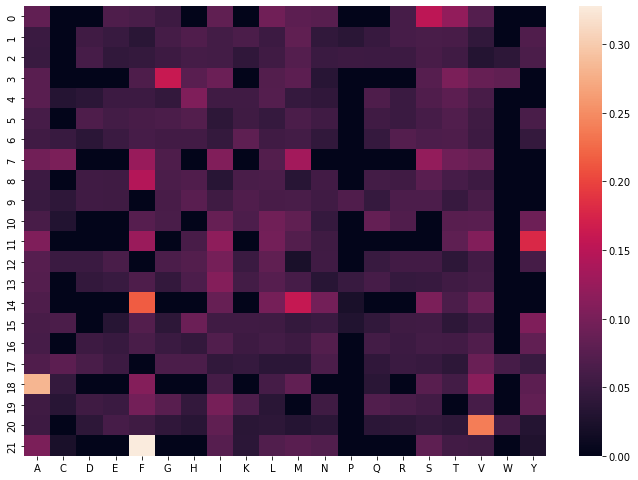

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.heatmap(matrix_imp, xticklabels=aa1)

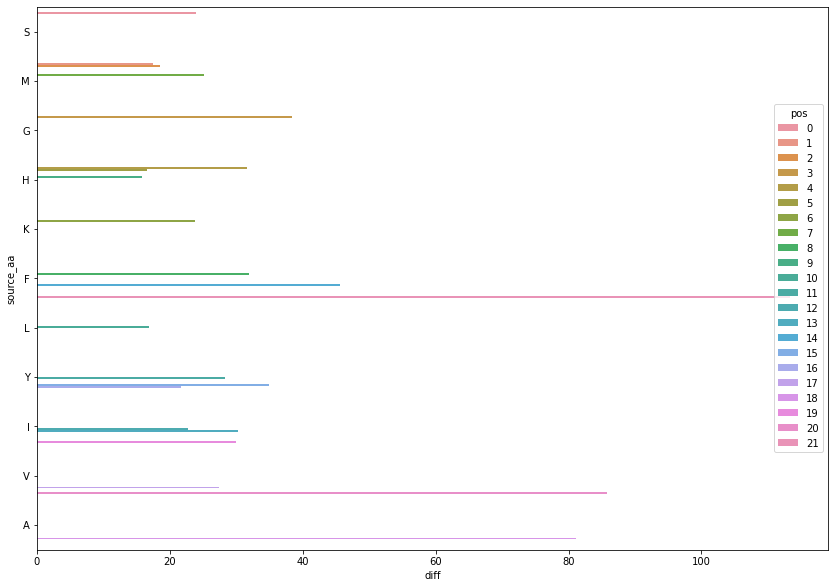

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.barplot(x='diff', y='source_aa' ,hue='pos', data=top_aa, ax=ax, orient='h')
plt.tight_layout()

In [55]:
ww = top_aa[top_aa.pos<4]